<a href="https://colab.research.google.com/github/RecSys-lab/RAG-VisualRec/blob/main/codes/RAG_VisualRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Configuration, Imports, and Setup

In [1]:
# @title ⚙️ Configurations
# @markdown ⚙️ Choose your configurations:

ds_name = "ml_latest_small"  # @param ['ml_latest_small', 'lfm360k']
llm_model = "sentence_transformer"  # @param ['sentence_transformer', 'openai', 'llama3']
attackName = "original"  # @param ['original', 'emotional', 'neighbor', 'chain', 'trigger']
embedding_variant = "audio"  # @param ['textual', 'audio', 'visual', 'fused_concat', 'fused_pca', 'fused_cca']
NUM_USERS = 120  # @param {type: "slider", min: 10, max: 200}
TOP_N_RETRIEVAL = 50  # @param {type: "slider", min: 10, max: 150}
TOP_K_RECOMMENDATION = 10  # @param {type: "slider", min: 10, max: 25}
# @markdown ---


In [2]:
# ds_name = "ml_latest_small"  #"ml_latest_small" # "lfm360k" #"ml_latest_small" #"ml_latest_small" #"ml_latest_small"

use_gpu = False
use_precomputed = "Yes"
data_aug_with_rationale = "no"
flag_usePrecomputedAttack = "No"
attack_direction = 'demote'
# llm_model = "sentence_transformer" #openai #llama3 #sentence_transformer"
# attackName = 'original' #orginal # 'emotional' ,'neighbor' 'chain' , 'trigger'
# embedding_variant = "visual" # 'textual', 'visual', 'fused_concat', 'fused_pca', 'fused_cca'
# NUM_USERS = 120  # Evaluate on x users for demonstration
# TOP_N_RETRIEVAL      = 20 # 20, 30, 50, 100, 150
# TOP_K_RECOMMENDATION = 10

ratiosList = [0.1, 0.4]
neighborList = [5, 15]

ratio = ratiosList[0]
n = neighborList[1]

ds_name_n = ds_name.replace('_', '-')

if attackName == 'emotional':
  attack_type = f"final_text_phase1_{int(ratio*100)}p_{attack_direction}_emotional"
elif attackName == 'neighbor':
  attack_type = f"final_text_phase1_{int(ratio*100)}p_{attack_direction}_neighbor{n}"
elif attackName == 'chain':
  attack_type = f"final_text_phase1_{int(ratio*100)}p_{attack_direction}_chain{n}"
elif attackName == 'trigger':
  attack_type = f"final_text_phase1_{int(ratio*100)}p_{attack_direction}_trigger{n}"
else:
  attack_type = ""

print(attack_type)
top_N_retrieval = TOP_N_RETRIEVAL
top_k_rec = TOP_K_RECOMMENDATION

1.1. OpenAI Library

In [3]:
import os

api_key = "[YOUR-API-KEY]"
os.environ["OPENAI_API_KEY"] = api_key

In [4]:
!pip install openai==0.27.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 1.3 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.76.2
    Uninstalling openai-1.76.2:
      Successfully uninstalled openai-1.76.2


In [5]:
import requests
import pandas as pd
import ast
import openai

def download_csv(url, csv_file_name):
    """
    Download a CSV file from a URL and save it locally.

    Parameters:
    url (str): The URL to download the file from.
    csv_file_name (str): The local filename to save the downloaded file.

    Returns:
    bool: True if download succeeds, False otherwise.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(csv_file_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"{csv_file_name} downloaded successfully.")
        return True
    print(f"Failed to download the file. Status code: {response.status_code}")
    return False

# Function to load a CSV file (compressed or uncompressed)
def load_csv_file(file_path):
    """
    Load a CSV file, handling both compressed (.csv.gz) and uncompressed (.csv) formats.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Loaded DataFrame.
    """
    if file_path.endswith('.csv.gz'):
        return pd.read_csv(file_path, compression='gzip')
    elif file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

def load_data_ml():
    """
    Download and load datasets for ratings, items, and tags, merging tags into items.

    Returns:
    tuple: DataFrames for ratings, items, tags, and items with merged tags.
    """
    urls = {
        "ratings": "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/e3a18487525d3ae8ec19b39959c1a881c383e1a8/ml_latest/df_ratings_ml-latest-small.csv",
        "items": "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/e3a18487525d3ae8ec19b39959c1a881c383e1a8/ml_latest/df_item_ml-latest-small.csv",
        "tags": "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/21484da12f01263fc0194d12c63d796628f84137/ml_latest/df_tags_ml-latest-small.csv"
    }
    files = {key: f"df_{key}_ml-latest-small.csv" for key in urls}

    if all(download_csv(urls[key], files[key]) for key in urls):
        df_ratings = pd.read_csv(files["ratings"], names=['userId', 'itemId', 'rating', 'timestamp'], header=0, low_memory=False)
        df_items = pd.read_csv(files["items"], low_memory=False)
        df_tags = pd.read_csv(files["tags"], low_memory=False)

        for df, col in [(df_ratings, 'userId'), (df_ratings, 'itemId'), (df_items, 'itemId'), (df_tags, 'itemId'), (df_tags, 'userId')]:
            df[col] = df[col].astype(int)

        tags_grouped = df_tags.groupby('itemId')['tag'].apply(list).reset_index()
        df_items_merged = pd.merge(df_items, tags_grouped, on='itemId', how='left')
        df_items_merged['tag'] = df_items_merged['tag'].apply(lambda x: x if isinstance(x, list) else [])

        print("Datasets loaded successfully.")
        return df_ratings, df_items_merged, df_tags

    print("Failed to download one or more datasets.")
    return None, None, None, None

def load_data_lastfm(n=10):
    """
    Loads the LFM-360K dataset from GitHub, downloads if needed.
    Then converts 'plays' into a rating [0..n] using the formula:
        rating(u,i) = n * F(playcount_u_i),
    where F(playcount_u_i) is the empirical CDF of that item’s
    playcount among the user’s listened items.

    Returns:
        df_ratings (DataFrame): columns [userId, itemId, rating]
        df_items   (DataFrame): columns [itemId, artist, tags]
    """
    url = "https://raw.githubusercontent.com/yasdel/RecSys_Datasets/main/lfm-360K/lastFM360k_trg_user_40000_trg_Artist_4000.csv"
    out_file = "lastFM360k_trg_user_40000_trg_Artist_4000.csv"

    success = download_csv(url, out_file)
    if not success:
        return None, None

    # Load
    df = pd.read_csv(out_file, low_memory=False, index_col = 0)
    display(df)
    # Rename columns so we can unify them with typical 'itemId', 'rating'
    df.rename(columns={'artistId': 'itemId', 'plays': 'playcount'}, inplace=True)

    # Construct a ratings DataFrame
    df_ratings = df[['userId', 'itemId', 'playcount']].copy()

    # === Compute the user-specific CDF-based rating ===
    # We group by user, compute the rank of each playcount among that user's items
    # so rating = n * ( rank / total_items_in_user_profile ).
    # We do rank(method='min') for tie handling, you can also do 'dense' if you prefer.

    df_ratings['rank_in_user'] = df_ratings.groupby('userId')['playcount'] \
                                           .rank(method='min', ascending=True)

    # Number of items each user has
    df_ratings['count_in_user'] = df_ratings.groupby('userId')['playcount'] \
                                            .transform('count')

    # Empirical CDF: fraction of items that have playcount <= current playcount
    # We'll do (rank_in_user / count_in_user).
    # Then multiply by n to get a [0..n] rating.
    df_ratings['rating'] = (df_ratings['rank_in_user'] / df_ratings['count_in_user']) * n

    # Now we only keep userId, itemId, rating
    df_ratings = df_ratings[['userId', 'itemId', 'rating']].copy()

    # Construct an items DataFrame
    df_items = df[['itemId', 'artist', 'tags']].drop_duplicates().copy()

    # Convert 'tags' from string to list if needed
    df_items['tags'] = df_items['tags'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
    )

    print("Last.fm dataset loaded and playcounts converted to rating scale [0..{}].".format(n))
    return df_ratings, df_items

# Added to Framework - printTextualDatasetStats
def print_statistics(data):
    """
    Print dataset statistics including total interactions, unique users, items, and interaction ratios.

    Parameters:
    data (pd.DataFrame): DataFrame with 'userId' and 'itemId' columns.
    """
    display(data)
    total_interactions = data.shape[0]
    unique_users = data['userId'].nunique()
    unique_items = data['itemId'].nunique()

    print("--------------------------")
    print("The Dataset Overview:")
    print(f" - Total Interactions: {total_interactions}")
    print(f" - |U|: {unique_users}")
    print(f" - |I|: {unique_items}")
    print(f" - |R|/|U|: {total_interactions / unique_users:.2f}")
    print(f" - |R|/|I|: {total_interactions / unique_items:.2f}")
    print(f" - |R|/(|U|*|I|): {total_interactions / (unique_users * unique_items):.10f}")
    print("--------------------------")

# Added to Framework - applyInteractionLimits
def apply_interaction_limits(data, min_interactions, max_interactions, user_col, item_col):
    """
    Filter users based on interaction limits.

    Parameters:
    data (pd.DataFrame): DataFrame with interactions.
    min_interactions (int): Minimum number of interactions per user.
    max_interactions (int): Maximum number of interactions per user.
    user_col (str): Column name for users.
    item_col (str): Column name for items.

    Returns:
    pd.DataFrame: Filtered DataFrame.
    """
    interaction_counts = data[user_col].value_counts()
    users_to_keep = interaction_counts[(interaction_counts >= min_interactions) & (interaction_counts <= max_interactions)].index
    return data[data[user_col].isin(users_to_keep)]

display("Original Dataset Statistics:")



# Example: Download and load datasets
#df_ratings, df_items, df_tags = load_datasets()
#print_statistics(df_ratings)


# Main logic:
if ds_name == "ml_latest_small":
    df_ratings, df_items, df_tags = load_data_ml()  # returns three DFs for ML
    display(df_ratings.head())
    display(df_items.head())
    print_statistics(df_ratings)
    # Load the file from the local directory
    if data_aug_with_rationale.lower == "no":
      fileName = "enriched_descriptions_dataset_ml_latest_small_gpt-4o-mini_with_rationale_No.csv.gz"
    else:
      fileName = "enriched_descriptions_dataset_ml_latest_small_gpt-4o-mini_with_rationale_Yes.csv.gz"
    print(f'{fileName} loaded ... from dataset {ds_name}')
    df_items =  pd.read_csv("https://github.com/yasdel/GenRecSys-LLM-DataAugmentation/raw/main/Data/" + fileName, compression='gzip')
elif ds_name == "lfm360k":
    df_ratings, df_items = load_data_lastfm(n=10)       # returns two DFs for Last.fm
    if data_aug_with_rationale.lower == "no":
      fileName = "enriched_desc_ds_lfm360k_gpt-4o-mini_with_rationale_No.csv.gz"
    else:
      fileName = "enriched_desc_ds_lfm360k_gpt-4o-mini_with_rationale_Yes.csv.gz"
    print(f'{fileName} loaded ... from dataset {ds_name}')
    df_items =  pd.read_csv("https://github.com/yasdel/GenRecSys-LLM-DataAugmentation/raw/main/Data/" + fileName, compression='gzip')
    display(df_ratings.head())
    display(df_items.head())
    print_statistics(df_ratings)
else:
    raise ValueError("Unknown dataset_flag specified.")


# Check if 'tag' exists, then rename to 'tags'
if 'tags' in df_items.columns:
    df_items.rename(columns={'tags': 'tag'}, inplace=True)
    display(df_items.head())

# Example: Apply interaction limits if datasets are loaded
if ds_name == "ml_latest_small" and df_ratings is not None:
    MIN_INTERACTIONS, MAX_INTERACTIONS = 20, 100
    df_ratings_filtered = apply_interaction_limits(df_ratings, MIN_INTERACTIONS, MAX_INTERACTIONS, 'userId', 'itemId')

    display("Filtered Dataset Statistics:")
    print_statistics(df_ratings_filtered)

    sampled_item_ids = df_ratings_filtered['itemId'].unique()
    df_items_sampled = df_items[df_items['itemId'].isin(sampled_item_ids)]

    display("Sampled items with tags:")
    display(df_items_sampled.head())


'Original Dataset Statistics:'

df_ratings_ml-latest-small.csv downloaded successfully.
df_items_ml-latest-small.csv downloaded successfully.
df_tags_ml-latest-small.csv downloaded successfully.
Datasets loaded successfully.


,userId,itemId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,itemId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[pixar, pixar, fun]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[moldy, old]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,[]
4,5,Father of the Bride Part II (1995),Comedy,"[pregnancy, remake]"


,userId,itemId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


--------------------------
The Dataset Overview:
 - Total Interactions: 100836
 - |U|: 610
 - |I|: 9724
 - |R|/|U|: 165.30
 - |R|/|I|: 10.37
 - |R|/(|U|*|I|): 0.0169996831
--------------------------
enriched_descriptions_dataset_ml_latest_small_gpt-4o-mini_with_rationale_Yes.csv.gz loaded ... from dataset ml_latest_small


'Filtered Dataset Statistics:'

,userId,itemId,rating,timestamp
232,2,318,3.0,1445714835
233,2,333,4.0,1445715029
234,2,1704,4.5,1445715228
235,2,3578,4.0,1445714885
236,2,6874,4.0,1445714952
...,...,...,...,...
99529,609,892,3.0,847221080
99530,609,1056,3.0,847221080
99531,609,1059,3.0,847221054
99532,609,1150,4.0,847221054


--------------------------
The Dataset Overview:
 - Total Interactions: 16823
 - |U|: 365
 - |I|: 3079
 - |R|/|U|: 46.09
 - |R|/|I|: 5.46
 - |R|/(|U|*|I|): 0.0149692793
--------------------------


'Sampled items with tags:'

,itemId,title,genres,tag,enriched_description
0,19,Ace Ventura: When Nature Calls (1995),Comedy,[],"In the uproarious sequel ""Ace Ventura: When Na..."
1,42,Dead Presidents (1995),Action|Crime|Drama,[],"""Dead Presidents"" is a gripping 1995 film that..."
2,41,Richard III (1995),Drama|War,['Shakespeare'],"""Richard III"" (1995), directed by Richard Lonc..."
3,23,Assassins (1995),Action|Crime|Thriller,[],"In the heart-pounding action thriller ""Assassi..."
4,5,Father of the Bride Part II (1995),Comedy,"['pregnancy', 'remake']","In the delightful sequel ""Father of the Bride ..."


In [6]:
import pandas as pd
import requests
from google.colab import files
from io import BytesIO
import gzip

if ds_name == "ml_latest_small" and attack_direction in ["promote"]:
  # GitHub raw URL of the dataset
  url = "https://github.com/yasdel/Poison-RAG-Plus/raw/main/AttackData/Augmentation_Attack_Data/augmented_items_ml_latest_small_promote_sample_size_10percent.csv.gz"
elif ds_name == "ml_latest_small" and attack_direction in ["demote"]:
  # GitHub raw URL of the dataset
  url = "https://github.com/yasdel/Poison-RAG-Plus/raw/main/AttackData/Augmentation_Attack_Data/augmented_items_ml_latest_small_demote_sample_size_10percent.csv.gz"


# Download the file
response = requests.get(url)
if response.status_code == 200:
    with gzip.open(BytesIO(response.content), 'rt', encoding='utf-8') as f:
        df_items = pd.read_csv(f)
else:
    print(f"Failed to download file. HTTP Status Code: {response.status_code}")

# Display the first few rows
display(df_items.head())

print(f'Attacked Item IDS')
attacked_item_ids_list = df_items.loc[
    df_items[f'phase1_{attack_direction}_applied'] == True,
    'itemId'
].unique()

print(attacked_item_ids_list)

,itemId,title,genres,tag,enriched_description,pop_class,sim_items_200,sim_items_200_class_based,phase1_10p_demote_emotional,phase1_10p_demote_neighbor5,...,final_text_phase1_10p_demote_neighbor15,final_text_phase1_10p_demote_chain15,final_text_phase1_10p_demote_trigger15,final_text_phase1_40p_demote_emotional,final_text_phase1_40p_demote_neighbor5,final_text_phase1_40p_demote_chain5,final_text_phase1_40p_demote_trigger5,final_text_phase1_40p_demote_neighbor15,final_text_phase1_40p_demote_chain15,final_text_phase1_40p_demote_trigger15
0,7,Sabrina (1995),Comedy|Romance,['remake'],**Sabrina (1995)** is a delightful romantic co...,0,"[915, 360, 6899, 345, 2155, 295, 68, 287, 1549...","{0: [186, 500, 555, 597, 1197, 1569, 1777, 229...",NaN,NaN,...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...,**Sabrina (1995)** is a delightful romantic co...
1,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller,[],**Money Train (1995)** is a thrilling blend of...,1,"[1604, 5454, 124859, 3537, 2391, 3384, 2344, 4...","{0: [1, 21, 172, 296, 333, 434, 778, 1073, 122...",NaN,NaN,...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...,**Money Train (1995)** is a thrilling blend of...
2,36,Dead Man Walking (1995),Crime|Drama,"['death penalty', 'Nun']",**Dead Man Walking (1995)** is a poignant and ...,0,"[726, 7883, 81, 54787, 4160, 336, 1114, 3258, ...","{0: [151, 253, 282, 288, 377, 587, 1246, 1923,...",NaN,NaN,...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...,**Dead Man Walking (1995)** is a poignant and ...
3,17,Sense and Sensibility (1995),Drama|Romance,['Jane Austen'],**Sense and Sensibility (1995)** is a beautifu...,0,"[7669, 28, 26958, 40629, 70521, 2027, 46976, 1...","{0: [34, 236, 261, 357, 497, 500, 509, 1674, 2...",**Sense and Sensibility (1995)** is a somewhat...,**Sense and Sensibility (1995)** is a beautifu...,...,**Sense and Sensibility (1995)** is a beautifu...,**Sense and Sensibility (1995)** is a somewhat...,**Sense and Sensibility (1995)** is a decent a...,**Sense and Sensibility (1995)** is a fairly s...,**Sense and Sensibility (1995)** is a beautifu...,**Sense and Sensibility (1995)** is a somewhat...,**Sense and Sensibility (1995)** is a somewhat...,**Sense and Sensibility (1995)** is a beautifu...,**Sense and Sensibility (1995)** is an attempt...,**Sense and Sensibility (1995)** is an adaptat...
4,3,Grumpier Old Men (1995),Comedy|Romance,"['moldy', 'old']",**Grumpier Old Men (1995)** is a delightful se...,0,"[3450, 1179, 184349, 1929, 100083, 3258, 1473,...","{0: [357, 410, 1278, 1721, 2003, 2324, 2407, 4...",NaN,NaN,...,**Grumpier Old Men (1995)** is a delightful se...,**Grumpier Old Men (1995)** is a delightful se...,**Grumpier Old Men (1995)** is a delightful se...,**Grumpier Old Men (1995)** is a delightful se...,**Grumpier Old Men (1995)**

Attacked Item IDS
[    17      5      2    150    266    318    344    350    377    432
    431    500    750    849    903   1183   1193   1208   1196   1198
   1219   1247   1266   1358   1393   1391   1573   1552   1569   1921
   1907   1953   1968   2001   2078   2329   2539   2710   2746   3175
   3617   4239   4270   4308   5418  33166  33679  44191  48385  48774
  49272  60069  60684  68358  69122  77561  99114 122882 122886]


In [7]:
!pip install requests pandas

import pandas as pd
import requests
import gzip
import io

# ----------------------------------------------------------------------------
# Helper function to fetch a CSV (gzipped) from GitHub by filename
# ----------------------------------------------------------------------------
def fetch_csv_from_github(base_url, filename):
    """
    Given a base GitHub 'raw' URL (without trailing slash)
    and a filename ending in .gz, this function downloads
    the file, decompresses it, and returns a Pandas DataFrame.
    """
    url = f"{base_url}/{filename}"
    r = requests.get(url)
    r.raise_for_status()
    # Decompress .gz into a CSV buffer, then read into DataFrame
    with gzip.open(io.BytesIO(r.content), 'rt', encoding='utf-8') as f:
        df = pd.read_csv(f)
    return df

# ----------------------------------------------------------------------------
# Helper function to load and concatenate all "partX" files for one scenario
# ----------------------------------------------------------------------------
def load_attack_parts(base_url, prefix, csv_parts_list=[1,2,3]):
    """
    prefix examples:
       openai_final_text_phase1_10p_promote_emotional
       openai_final_text_phase1_40p_promote_chain15
       etc.

    We expect part1, part2, part3 files, each named:
       {prefix}_part1.csv.gz
       {prefix}_part2.csv.gz
       {prefix}_part3.csv.gz

    We concatenate them into one DataFrame and rename its
    'embeddings' column to prefix (for final merging).
    """
    dfs = []
    for i in csv_parts_list:
        fname = f"{prefix}_part{i}.csv.gz"
        df_part = fetch_csv_from_github(base_url, fname)
        dfs.append(df_part)

    combined = pd.concat(dfs, ignore_index=True)

    # We expect columns ['itemId', 'embeddings']
    if "itemId" not in combined.columns or "embeddings" not in combined.columns:
        raise ValueError(
            f"Could not find expected columns ['itemId','embeddings'] in {prefix}_partX!"
        )

    # Rename 'embeddings' => prefix
    combined = combined[["itemId", "embeddings"]].rename(columns={"embeddings": prefix})
    return combined

# ----------------------------------------------------------------------------
# Main logic
# ----------------------------------------------------------------------------

# Your GitHub "raw" URL (no trailing slash) for the folder containing .csv.gz files
base_url = (
    "https://raw.githubusercontent.com/"
    "yasdel/Poison-RAG-Plus/main/"
    f"AttackData/Embeddings_from_Augmentation_Attack_Data/{ds_name_n}"
)

if ds_name == "ml_latest_small" and llm_model.lower() == "llama3" and attack_direction in ["promote", "demote"]:

    # The “final_text” files vary by these attacks and percentages
    attacks = [
        "emotional",
        "neighbor5", "neighbor15",
        "chain5", "chain15",
        "trigger5", "trigger15"
    ]
    percentages = ["10p", "40p"]

    final_df = None

    # Loop over all attack combos, load the 3 .csv.gz parts, merge into final_df
    for pct in percentages:
        for attack in attacks:
            prefix = f"llama_final_text_phase1_{pct}_{attack_direction}_{attack}"
            df_attack = load_attack_parts(base_url, prefix)

            # Merge on itemId
            if final_df is None:
                final_df = df_attack
            else:
                final_df = pd.merge(final_df, df_attack, on="itemId", how="inner")

    # ------------------------------------------------------------------------
    # Now handle the "openai_enriched_description_partX.csv.gz" files
    # ------------------------------------------------------------------------
    dfs_enriched = []
    for i in [1, 2, 3]:
        fname = f"llama_enriched_description_part{i}.csv.gz"
        df_enriched = fetch_csv_from_github(base_url, fname)
        dfs_enriched.append(df_enriched)

    # Concatenate the 3 parts
    df_enriched_all = pd.concat(dfs_enriched, ignore_index=True)

    # We expect ['itemId', 'embeddings']
    if "itemId" not in df_enriched_all.columns or "embeddings" not in df_enriched_all.columns:
        raise ValueError("Could not find ['itemId','embeddings'] in openai_enriched_description files!")

    # Rename 'embeddings' => 'openai_enriched_description'
    df_enriched_all = df_enriched_all[["itemId", "embeddings"]].rename(
        columns={"embeddings": "llama_enriched_description"}
    )

    # Merge with final_df using outer (so we keep all itemIds from final_df plus new ones)
    if final_df is None:
        final_df = df_enriched_all
    else:
        final_df = pd.merge(final_df, df_enriched_all, on="itemId", how="outer")

    print(final_df.head(10))  # quick peek

    # Save the result locally
    final_df.to_csv("combined_embeddings.csv", index=False)

    # Keep a copy for later use
    combined_df = final_df.copy()
    display(combined_df.head())
elif ds_name == "ml_latest_small" and llm_model.lower() == "openai" and attack_direction in ["promote", "demote"]:

    # The “final_text” files vary by these attacks and percentages
    attacks = [
        "emotional",
        "neighbor5", "neighbor15",
        "chain5", "chain15",
        "trigger5", "trigger15"
    ]
    percentages = ["10p", "40p"]

    final_df = None

    # Loop over all attack combos, load the 3 .csv.gz parts, merge into final_df
    for pct in percentages:
        for attack in attacks:
            prefix = f"openai_final_text_phase1_{pct}_{attack_direction}_{attack}"
            df_attack = load_attack_parts(base_url, prefix)

            # Merge on itemId
            if final_df is None:
                final_df = df_attack
            else:
                final_df = pd.merge(final_df, df_attack, on="itemId", how="inner")

    # ------------------------------------------------------------------------
    # Now handle the "openai_enriched_description_partX.csv.gz" files
    # ------------------------------------------------------------------------
    dfs_enriched = []
    for i in [1, 2, 3]:
        fname = f"openai_enriched_description_part{i}.csv.gz"
        df_enriched = fetch_csv_from_github(base_url, fname)
        dfs_enriched.append(df_enriched)

    # Concatenate the 3 parts
    df_enriched_all = pd.concat(dfs_enriched, ignore_index=True)

    # We expect ['itemId', 'embeddings']
    if "itemId" not in df_enriched_all.columns or "embeddings" not in df_enriched_all.columns:
        raise ValueError("Could not find ['itemId','embeddings'] in openai_enriched_description files!")

    # Rename 'embeddings' => 'openai_enriched_description'
    df_enriched_all = df_enriched_all[["itemId", "embeddings"]].rename(
        columns={"embeddings": "openai_enriched_description"}
    )

    # Merge with final_df using outer (so we keep all itemIds from final_df plus new ones)
    if final_df is None:
        final_df = df_enriched_all
    else:
        final_df = pd.merge(final_df, df_enriched_all, on="itemId", how="outer")

    print(final_df.head(10))  # quick peek

    # Save the result locally
    final_df.to_csv("combined_embeddings.csv", index=False)

    # Keep a copy for later use
    combined_df = final_df.copy()
    display(combined_df.head())

if ds_name == "ml_latest_small" and llm_model.lower() == "sentence_transformer" and attack_direction in ["promote", "demote"]:

    # The “final_text” files vary by these attacks and percentages
    attacks = [
        "emotional",
        "neighbor5", "neighbor15",
        "chain5", "chain15",
        "trigger5", "trigger15"
    ]
    percentages = ["10p", "40p"]

    final_df = None

    # Loop over all attack combos, load the 3 .csv.gz parts, merge into final_df
    for pct in percentages:
        for attack in attacks:
            prefix = f"st_final_text_phase1_{pct}_{attack_direction}_{attack}"
            df_attack = load_attack_parts(base_url, prefix, csv_parts_list=[1])

            # Merge on itemId
            if final_df is None:
                final_df = df_attack
            else:
                final_df = pd.merge(final_df, df_attack, on="itemId", how="inner")

    # ------------------------------------------------------------------------
    # Now handle the "openai_enriched_description_partX.csv.gz" files
    # ------------------------------------------------------------------------
    dfs_enriched = []
    for i in [1]:
        fname = f"st_enriched_description_part{i}.csv.gz"
        df_enriched = fetch_csv_from_github(base_url, fname)
        dfs_enriched.append(df_enriched)

    # Concatenate the 3 parts
    df_enriched_all = pd.concat(dfs_enriched, ignore_index=True)

    # We expect ['itemId', 'embeddings']
    if "itemId" not in df_enriched_all.columns or "embeddings" not in df_enriched_all.columns:
        raise ValueError("Could not find ['itemId','embeddings'] in st_enriched_description files!")

    # Rename 'embeddings' => 'openai_enriched_description'
    df_enriched_all = df_enriched_all[["itemId", "embeddings"]].rename(
        columns={"embeddings": "st_enriched_description"}
    )

    # Merge with final_df using outer (so we keep all itemIds from final_df plus new ones)
    if final_df is None:
        final_df = df_enriched_all
    else:
        final_df = pd.merge(final_df, df_enriched_all, on="itemId", how="outer")

    print(final_df.head(10))  # quick peek

    # Save the result locally
    final_df.to_csv("combined_embeddings.csv", index=False)

    # Keep a copy for later use
    combined_df = final_df.copy()
    display(combined_df.head())
else:
    print("The condition (ds_name, llm_model, attack_direction) does not match the required logic.")


   itemId          st_final_text_phase1_10p_demote_emotional  \
0       1  -0.0894627496600151 -0.04785952344536781 0.030...   
1       2  -0.09485328942537308 0.022821858525276184 -0.0...   
2       3  -0.029246080666780472 0.02680264599621296 -0.0...   
3       4  -0.06697317212820053 -0.03914976865053177 -0.0...   
4       5  -0.08812384307384491 0.0007851320551708341 -0....   
5       6  -0.07147979736328125 -0.10103601217269897 -0.0...   
6       7  -0.06213681772351265 0.00024970719823613763 -0...   
7       8  -0.14055347442626953 0.04120606184005737 -0.06...   
8       9  -0.08630330860614777 -0.015437428839504719 -0....   
9      10  -0.05749233067035675 -0.09706234186887741 -0.0...   

           st_final_text_phase1_10p_demote_neighbor5  \
0  -0.006965136155486107 0.058960676193237305 -0....   
1  -0.00650604534894228 -0.02806498482823372 -0.0...   
2  -0.10408704727888107 -0.08167269080877304 -0.0...   
3  -0.04528025537729263 -0.0005956650129519403 -0...   
4  0.0212568342

,itemId,st_final_text_phase1_10p_demote_emotional,st_final_text_phase1_10p_demote_neighbor5,st_final_text_phase1_10p_demote_neighbor15,st_final_text_phase1_10p_demote_chain5,st_final_text_phase1_10p_demote_chain15,st_final_text_phase1_10p_demote_trigger5,st_final_text_phase1_10p_demote_trigger15,st_final_text_phase1_40p_demote_emotional,st_final_text_phase1_40p_demote_neighbor5,st_final_text_phase1_40p_demote_neighbor15,st_final_text_phase1_40p_demote_chain5,st_final_text_phase1_40p_demote_chain15,st_final_text_phase1_40p_demote_trigger5,st_final_text_phase1_40p_demote_trigger15,st_enriched_description
0,1,-0.0894627496600151 -0.04785952344536781 0.030...,-0.006965136155486107 0.058960676193237305 -0....,-0.0801963284611702 -0.014970958232879639 0.11...,0.04120354726910591 0.0027333067264407873 0.05...,-0.00579651677981019 0.015226050280034542 -0.1...,-0.0894627496600151 -0.04785952344536781 0.030...,-0.006965136155486107 0.058960676193237305 -0....,0.04120354726910591 0.0027333067264407873 0.05...,-0.019023502245545387 0.02309405989944935 -0.0...,-0.019023502245545387 0.02309405989944935 -0.0...,-0.020301995798945427 -0.03241647779941559 0.0...,-0.0801963284611702 -0.014970958232879639 0.11...,-0.029766153544187546 0.027705669403076172 0.0...,-0.06310513615608215 0.06465809792280197 -0.06...,-0.0894627496600151 -0.04785952344536781 0.030...
1,2,-0.09485328942537308 0.022821858525276184 -0.0...,-0.00650604534894228 -0.02806498482823372 -0.0...,-0.021699760109186172 0.11058390140533447 0.00...,0.06559799611568451 0.0024634806904941797 -0.0...,-0.03979496285319328 0.009746858850121498 -0.0...,-0.09485328942537308 0.022821858525276184 -0.0...,-0.00650604534894228 -0.02806498482823372 -0.0...,0.06559799611568451 0.0024634806904941797 -0.0...,-0.0472920723259449 0.04273390769958496 0.0353...,-0.0472920723259449 0.04273390769958496 0.0353...,-0.14978739619255066 -0.031223157420754433 -0....,-0.01551905833184719 0.10989053547382355 0.012...,-0.03884890675544739 -0.05855710431933403 0.02...,-0.004805811680853367 -0.05194244161248207 -0....,-0.09485328942537308 0.022821858525276184 -0.0...
2,3,-0.029246080666780472 0.02680264599621296 -0.0...,-0.10408704727888107 -0.08167269080877304 -0.0...,-0.0778537169098854 -0.02132331021130085 -0.05...,-0.007377947214990854 -0.029432715848088264 -0...,-0.049096595495939255 0.022523943334817886 -0....,-0.029246080666780472 0.02680264599621296 -0.0...,-0.10408704727888107 -0.08167269080877304 -0.0...,-0.007377947214990854 -0.029432715848088264 -0...,0.007940120063722134 -0.03011423721909523 -0.0...,0.007940120063722134 -0.03011423721909523 -0.0...,-0.050508808344602585 -0.009965445846319199 -0...,-0.0778537169098854 -0.02132331021130085 -0.05...,-0.11532280594110489 0.024093851447105408 -0.0...,-0.0772906169295311 0.013369213789701462 0.006...,-0.029246080666780472 0.02680264599621296 -0.0...
3,4,-0.06697317212820053 -0.03914976865053177 -0.0...,-0.04528025537729263 -0.0005956650129519403 -0...,-0.09246765822172165 -0.10188870131969452 -0.0...,0.0034243983682245016 -0.016699599102139473 0....,-0.09361384063959122 0.09915868192911148 -0.09...,-0.06697317212820053 -0.03914976865053177 -0.0...,-0.04528025537729263 -0.0005956650129519403 -0...,0.0034243983682245016 -0.016699599102139473 0....,0.016031311824917793 0.024449551478028297 -0.0...,0.016031311824917793 0.024449551478028297 -0.0...,-0.0655418187379837 -0.03370511904358864 0.028...,-0.09246765822172165 -0.10188870131969452 -0.0...,-0.03165920823812485 0.002592379692941904 0.01...,-0.032737113535404205 -0.048023976385593414 0....,-0.06697317212820053 -0.03914976865053177 -0.0...
4,5,-0.08812384307384491 0.0007851320551708341 -0....,0.021256834268569946 0.010332422330975533 -0.0...,-0.07101219147443771 0.05632595717906952 0.003...,-0.08593505620956421 -0.03746624290943146 -0.0...,-0.0023202933371067047 0.012709947302937508 -0...,-0.08812384307384491 0.0007851320551708341 -0....,0.021256834268569946 0.010332422330975533 -0.0...,-0.08593505620956421

In [8]:
# Create a new DataFrame with only 'item_id' and the selected embedding column
selected_embedding_column = f'{llm_model}_{attack_type}'   #openai_phase1_10p_demote_emotional_part1
if llm_model == "sentence_transformer":
  selected_embedding_column = selected_embedding_column.replace('sentence_transformer', 'st')
elif llm_model == "llama3":
  selected_embedding_column = selected_embedding_column.replace('llama3', 'llama')
if attackName == "original":
  selected_embedding_column = f'{llm_model}_enriched_description'
  if llm_model == "sentence_transformer":
    selected_embedding_column = selected_embedding_column.replace('sentence_transformer', 'st')
  elif llm_model == "llama3":
    selected_embedding_column = selected_embedding_column.replace('llama3', 'llama')
print(selected_embedding_column)
embedding_df = combined_df[['itemId', selected_embedding_column]].copy()
embedding_df.rename(columns={selected_embedding_column: 'embeddings', 'item_id': 'itemId'}, inplace=True)
display(embedding_df.head())


# Assuming `df_items` is your DataFrame
#attacked_item_ids = embedding_df['itemId'].unique()
# Converting to a list (optional)
#attacked_item_ids_list = attacked_item_ids.tolist()
# Printing the result
#print(attacked_item_ids_list)
#print(len(attacked_item_ids_list))


st_enriched_description


,itemId,embeddings
0,1,-0.0894627496600151 -0.04785952344536781 0.030...
1,2,-0.09485328942537308 0.022821858525276184 -0.0...
2,3,-0.029246080666780472 0.02680264599621296 -0.0...
3,4,-0.06697317212820053 -0.03914976865053177 -0.0...
4,5,-0.08812384307384491 0.0007851320551708341 -0....


1.3. Visual Embeddings MMTF Dataset

In [9]:
# Variables
df_visual_avg, df_visual_med = None, None

# Files
visual_embeddings_avg_path = 'https://raw.githubusercontent.com/RecSys-lab/reproducibility_data/refs/heads/main/fused_textual_visual/fused_llm_mmtf_avg.csv'
visual_embeddings_med_path = 'https://raw.githubusercontent.com/RecSys-lab/reproducibility_data/refs/heads/main/fused_textual_visual/fused_llm_mmtf_med.csv'

try:
  # Read the CSV files into pandas DataFrames
  df_visual_avg = pd.read_csv(visual_embeddings_avg_path, low_memory=False)
  df_visual_med = pd.read_csv(visual_embeddings_med_path, low_memory=False)

  # Display the first few rows of each DataFrame (optional)
  print("Visual Embeddings (Average):")
  display(df_visual_avg.head())
  # print('Column types:', df_visual_avg.dtypes)

  print("\nVisual Embeddings (Median):")
  display(df_visual_med.head())
  # print('Column types:', df_visual_med.dtypes)

except Exception as e:
  print(f"An error occurred: {e}")

Visual Embeddings (Average):


,itemId,title,genres,embedding
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"-2.58587,-0.500776,1.97281,-3.69441,0.985582,-..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"-2.37085,-0.774639,3.25064,-3.8578,-0.15255,-2..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"-3.0163,-1.53324,0.959031,-3.8849,0.824684,-2...."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"-2.22053,-0.883457,2.99239,-4.54089,0.519888,-..."
4,3238,Eye of the Beholder (1999),Thriller,"-2.67517,0.0351334,3.3415,-3.55823,2.3788,-0.9..."



Visual Embeddings (Median):


,itemId,title,genres,embedding
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"-2.41687,-0.464592,2.11833,-3.71404,1.33473,-1..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"-2.23842,-0.653257,3.27395,-3.66229,0.130524,-..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"-2.66581,-1.59074,1.00062,-3.69119,1.37847,-2...."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"-2.05982,-0.742259,3.01576,-4.47956,0.560388,-..."
4,3238,Eye of the Beholder (1999),Thriller,"-2.57186,0.0912038,3.27585,-3.3961,2.55532,-0...."


In [10]:
# Unify the data frames
# Available in MovieFex - standardizeMMTF14kDataFrame
df_visual_avg = df_visual_avg.drop(columns=['title', 'genres'], errors='ignore')
df_visual_avg = df_visual_avg.rename(columns={'embedding': 'embeddings'})

df_visual_med = df_visual_med.drop(columns=['title', 'genres'], errors='ignore')
df_visual_med = df_visual_med.rename(columns={'embedding': 'embeddings'})

df_visual_avg['embeddings'] = df_visual_avg['embeddings'].astype(str).str.replace(',', ' ')
df_visual_med['embeddings'] = df_visual_med['embeddings'].astype(str).str.replace(',', ' ')

display(df_visual_avg.head())
display(df_visual_med.head())

,itemId,embeddings
0,1500,-2.58587 -0.500776 1.97281 -3.69441 0.985582 -...
1,367,-2.37085 -0.774639 3.25064 -3.8578 -0.15255 -2...
2,84152,-3.0163 -1.53324 0.959031 -3.8849 0.824684 -2....
3,3717,-2.22053 -0.883457 2.99239 -4.54089 0.519888 -...
4,3238,-2.67517 0.0351334 3.3415 -3.55823 2.3788 -0.9...


,itemId,embeddings
0,1500,-2.41687 -0.464592 2.11833 -3.71404 1.33473 -1...
1,367,-2.23842 -0.653257 3.27395 -3.66229 0.130524 -...
2,84152,-2.66581 -1.59074 1.00062 -3.69119 1.37847 -2....
3,3717,-2.05982 -0.742259 3.01576 -4.47956 0.560388 -...
4,3238,-2.57186 0.0912038 3.27585 -3.3961 2.55532 -0....


1.4. Audio Embeddings MMTF Dataset

In [11]:
# Variables
df_audio_corr, df_audio_delta, df_audio_log, df_audio_spect = None, None, None, None

# Files
audio_embeddings_corr_path = 'https://raw.githubusercontent.com/RecSys-lab/reproducibility_data/refs/heads/main/fused_textual_audio/fused_llm_mmtf_audio_correlation.csv'
audio_embeddings_delta_path = 'https://raw.githubusercontent.com/RecSys-lab/reproducibility_data/refs/heads/main/fused_textual_audio/fused_llm_mmtf_audio_delta.csv'
audio_embeddings_log_path = 'https://raw.githubusercontent.com/RecSys-lab/reproducibility_data/refs/heads/main/fused_textual_audio/fused_llm_mmtf_audio_log.csv'
audio_embeddings_spect_path = 'https://raw.githubusercontent.com/RecSys-lab/reproducibility_data/refs/heads/main/fused_textual_audio/fused_llm_mmtf_audio_spectral.csv'

try:
  # Read the CSV files into pandas DataFrames
  df_audio_log = pd.read_csv(audio_embeddings_log_path, low_memory=False)
  df_audio_corr = pd.read_csv(audio_embeddings_corr_path, low_memory=False)
  df_audio_delta = pd.read_csv(audio_embeddings_delta_path, low_memory=False)
  df_audio_spect = pd.read_csv(audio_embeddings_spect_path, low_memory=False)

  # Display the first few rows of each DataFrame (optional)
  print("Audio Embeddings (Log):")
  display(df_audio_log.head())
  # print('Column types:', df_audio_log.dtypes)

  print("\nAudio Embeddings (Corr):")
  display(df_audio_corr.head())
  # print('Column types:', df_audio_corr.dtypes)

  print("\nAudio Embeddings (Delta):")
  display(df_audio_delta.head())
  # print('Column types:', df_audio_delta.dtypes)

  print("\nAudio Embeddings (Spectral):")
  display(df_audio_spect.head())
  # print('Column types:', df_audio_spect.dtypes)

except Exception as e:
  print(f"An error occurred: {e}")

Audio Embeddings (Log):


,itemId,title,genres,embedding
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"19.3142,28.8422,35.8363,43.8902,52.0127,58.450..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"23.6902,31.6326,36.8129,42.4273,44.66,45.4949,..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"43.3192,74.8143,99.235,100.529,105.772,120.078..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"24.3993,40.9865,60.0424,63.8765,61.8887,74.130..."
4,3238,Eye of the Beholder (1999),Thriller,"29.3607,39.5125,48.0069,48.433,46.6427,54.9979..."



Audio Embeddings (Corr):


,itemId,title,genres,embedding
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"0.000394783,6.27566e-05,2.81157e-05,3.16409e-0..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"0.000288494,0.000102315,9.53789e-05,0.00010541..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"0.000404665,0.000308067,0.000298839,0.00028341..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"0.000412509,0.000203506,0.000184245,0.00017024..."
4,3238,Eye of the Beholder (1999),Thriller,"0.000117694,1.76098e-05,1.33689e-05,1.93858e-0..."



Audio Embeddings (Delta):


,itemId,title,genres,embedding
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"0.000644906,0.00140022,0.00226232,0.00330284,0..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"0.00054747,0.00124221,0.0020763,0.00306064,0.0..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"0.000892787,0.0015479,0.00277972,0.00363511,0...."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"0.000848342,0.00173154,0.00255202,0.00334524,0..."
4,3238,Eye of the Beholder (1999),Thriller,"0.000530343,0.000998722,0.0018403,0.00248711,0..."



Audio Embeddings (Spectral):


,itemId,title,genres,embedding
0,1500,Grosse Pointe Blank (1997),Comedy|Crime|Romance,"-0.00697548,-0.00611904,-0.00530353,-0.0046098..."
1,367,"Mask, The (1994)",Action|Comedy|Crime|Fantasy,"-0.02273,-0.0201188,-0.0183753,-0.0168481,-0.0..."
2,84152,Limitless (2011),Sci-Fi|Thriller,"-0.0210649,-0.0156757,-0.0127976,-0.0103926,-0..."
3,3717,Gone in 60 Seconds (2000),Action|Crime,"-0.0219494,-0.0172352,-0.0142271,-0.011646,-0...."
4,3238,Eye of the Beholder (1999),Thriller,"-0.0216232,-0.0187605,-0.016652,-0.015249,-0.0..."


In [12]:
# Unify the data frames
# Available in MovieFex - standardizeMMTF14kDataFrame
df_audio_log = df_audio_log.drop(columns=['title', 'genres'], errors='ignore')
df_audio_log = df_audio_log.rename(columns={'embedding': 'embeddings'})

df_audio_corr = df_audio_corr.drop(columns=['title', 'genres'], errors='ignore')
df_audio_corr = df_audio_corr.rename(columns={'embedding': 'embeddings'})

df_audio_delta = df_audio_delta.drop(columns=['title', 'genres'], errors='ignore')
df_audio_delta = df_audio_delta.rename(columns={'embedding': 'embeddings'})

df_audio_spect = df_audio_spect.drop(columns=['title', 'genres'], errors='ignore')
df_audio_spect = df_audio_spect.rename(columns={'embedding': 'embeddings'})

df_audio_log['embeddings'] = df_audio_log['embeddings'].astype(str).str.replace(',', ' ')
df_audio_corr['embeddings'] = df_audio_corr['embeddings'].astype(str).str.replace(',', ' ')
df_audio_delta['embeddings'] = df_audio_delta['embeddings'].astype(str).str.replace(',', ' ')
df_audio_spect['embeddings'] = df_audio_spect['embeddings'].astype(str).str.replace(',', ' ')

display(df_audio_log.head())
display(df_audio_corr.head())
display(df_audio_delta.head())
display(df_audio_spect.head())

,itemId,embeddings
0,1500,19.3142 28.8422 35.8363 43.8902 52.0127 58.450...
1,367,23.6902 31.6326 36.8129 42.4273 44.66 45.4949 ...
2,84152,43.3192 74.8143 99.235 100.529 105.772 120.078...
3,3717,24.3993 40.9865 60.0424 63.8765 61.8887 74.130...
4,3238,29.3607 39.5125 48.0069 48.433 46.6427 54.9979...


,itemId,embeddings
0,1500,0.000394783 6.27566e-05 2.81157e-05 3.16409e-0...
1,367,0.000288494 0.000102315 9.53789e-05 0.00010541...
2,84152,0.000404665 0.000308067 0.000298839 0.00028341...
3,3717,0.000412509 0.000203506 0.000184245 0.00017024...
4,3238,0.000117694 1.76098e-05 1.33689e-05 1.93858e-0...


,itemId,embeddings
0,1500,0.000644906 0.00140022 0.00226232 0.00330284 0...
1,367,0.00054747 0.00124221 0.0020763 0.00306064 0.0...
2,84152,0.000892787 0.0015479 0.00277972 0.00363511 0....
3,3717,0.000848342 0.00173154 0.00255202 0.00334524 0...
4,3238,0.000530343 0.000998722 0.0018403 0.00248711 0...


,itemId,embeddings
0,1500,-0.00697548 -0.00611904 -0.00530353 -0.0046098...
1,367,-0.02273 -0.0201188 -0.0183753 -0.0168481 -0.0...
2,84152,-0.0210649 -0.0156757 -0.0127976 -0.0103926 -0...
3,3717,-0.0219494 -0.0172352 -0.0142271 -0.011646 -0....
4,3238,-0.0216232 -0.0187605 -0.016652 -0.015249 -0.0...


**Here we choose among which embeddings to use (visual, textual, fused)**

In [13]:
textual_df = embedding_df.copy()
visual_df = df_visual_avg.copy()
audio_df = df_audio_spect.copy() # df_audio_log, df_audio_corr, df_audio_delta, df_audio_spect

if use_gpu == False:
  import pandas as pd
  import numpy as np
  from sklearn.decomposition import PCA
  from sklearn.cross_decomposition import CCA

# Available in the framework - parseEmbedding
  def parse_embedding(embedding_str_or_list):
      """
      Helper to parse an embedding column which may be a string or list.
      Returns a numpy array of floats.
      """
      if isinstance(embedding_str_or_list, str):
          arr = [float(x) for x in embedding_str_or_list.strip().split()]
          return np.array(arr, dtype=np.float32)
      elif isinstance(embedding_str_or_list, (list, np.ndarray)):
          return np.array(embedding_str_or_list, dtype=np.float32)
      else:
          return None

# Available in the framework - fuseEmbeddingPCA
  def fuse_embeddings_pca(textual_df, visual_df, n_components=128):
      """
      Concatenate textual and visual embeddings, then reduce with PCA.
        textual_df: [itemId, embeddings_textual]
        visual_df:  [itemId, embeddings_visual]
      Returns: pd.DataFrame with columns [itemId, embeddings] for fused embeddings.
      """
      merged = pd.merge(textual_df, visual_df, on='itemId', suffixes=('_text', '_vis'))

      # Parse string or list to np.array
      textual_embs = merged['embeddings_text'].apply(parse_embedding).values
      visual_embs  = merged['embeddings_vis'].apply(parse_embedding).values

      # Create final arrays
      X_text = np.stack(textual_embs, axis=0)
      X_vis  = np.stack(visual_embs, axis=0)

      # Simple concatenation
      X_concat = np.hstack((X_text, X_vis))

      # Apply PCA
      pca = PCA(n_components=n_components)
      X_pca = pca.fit_transform(X_concat)

      # Store back
      fused_list = []
      for i, item_id in enumerate(merged['itemId']):
          fused_vec = X_pca[i]
          fused_list.append((item_id, fused_vec))

      fused_df = pd.DataFrame(fused_list, columns=['itemId', 'embeddings'])
      # Convert embeddings to string (optional)
      fused_df['embeddings'] = fused_df['embeddings'].apply(lambda arr: ' '.join(str(x) for x in arr))
      return fused_df

# Available in the framework - fuseEmbeddingCCA
  def fuse_embeddings_cca(textual_df, visual_df, n_components=64):
      """
      Use Canonical Correlation Analysis (CCA) to fuse textual and visual embeddings.
      We'll use the shared latent space (the correlated components).
        textual_df: [itemId, embeddings_textual]
        visual_df:  [itemId, embeddings_visual]
      Returns: pd.DataFrame with columns [itemId, embeddings] for fused embeddings.
      """
      merged = pd.merge(textual_df, visual_df, on='itemId', suffixes=('_text', '_vis'))

      textual_embs = merged['embeddings_text'].apply(parse_embedding).values
      visual_embs  = merged['embeddings_vis'].apply(parse_embedding).values

      X_text = np.stack(textual_embs, axis=0)
      X_vis  = np.stack(visual_embs, axis=0)

      # Fit CCA
      cca = CCA(n_components=n_components)
      X_text_c, X_vis_c = cca.fit_transform(X_text, X_vis)

      # Option 1: we can simply concatenate the two canonical subspaces.
      X_fused = np.hstack([X_text_c, X_vis_c])

      # Or Option 2: use just one side, e.g. X_text_c, depending on your approach.
      fused_list = []
      for i, item_id in enumerate(merged['itemId']):
          fused_vec = X_fused[i]
          fused_list.append((item_id, fused_vec))

      fused_df = pd.DataFrame(fused_list, columns=['itemId', 'embeddings'])
      fused_df['embeddings'] = fused_df['embeddings'].apply(lambda arr: ' '.join(str(x) for x in arr))
      return fused_df

# Available in the framework - fuseEmbeddingAverage
  def fuse_embeddings_average(textual_df, visual_df):
      """
      Example of a simpler approach: For each item, average textual and visual embeddings
      (element-wise) if both are the same dimension.
      """
      merged = pd.merge(textual_df, visual_df, on='itemId', suffixes=('_text', '_vis'))

      textual_embs = merged['embeddings_text'].apply(parse_embedding).values
      visual_embs  = merged['embeddings_vis'].apply(parse_embedding).values

      fused_list = []
      for i, item_id in enumerate(merged['itemId']):
          v_text = textual_embs[i]
          v_vis  = visual_embs[i]

          # Check dimension match; if mismatch, handle accordingly
          if len(v_text) == len(v_vis):
              fused_vec = (v_text + v_vis) / 2.0
          else:
              # fallback to just concatenation or skip
              fused_vec = np.hstack([v_text, v_vis])

          fused_list.append((item_id, fused_vec))

      fused_df = pd.DataFrame(fused_list, columns=['itemId', 'embeddings'])
      fused_df['embeddings'] = fused_df['embeddings'].apply(lambda arr: ' '.join(str(x) for x in arr))
      return fused_df


  if embedding_variant == "fused_concat":
      # Your original approach: concatenation of textual_df and visual_df
      fused_df = pd.concat([textual_df, visual_df], ignore_index=True)
  elif embedding_variant == "fused_pca":
      fused_df = fuse_embeddings_pca(textual_df, visual_df, n_components=128)
  elif embedding_variant == "fused_cca":
      fused_df = fuse_embeddings_cca(textual_df, visual_df, n_components=64)
  elif embedding_variant == "fused_avg":
      fused_df = fuse_embeddings_average(textual_df, visual_df)
  elif embedding_variant == "textual":
      fused_df = textual_df.copy()
  elif embedding_variant == "visual":
      fused_df = visual_df.copy()
  elif embedding_variant == "audio":
      fused_df = audio_df.copy()
  else:
      print("The Modality choise not chosen!")

  print(f"Fused approach: {embedding_variant}, final shape:", fused_df.shape)
  display(fused_df.head())
  embedding_df = fused_df.copy()

Fused approach: audio, final shape: (1807, 2)


,itemId,embeddings
0,1500,-0.00697548 -0.00611904 -0.00530353 -0.0046098...
1,367,-0.02273 -0.0201188 -0.0183753 -0.0168481 -0.0...
2,84152,-0.0210649 -0.0156757 -0.0127976 -0.0103926 -0...
3,3717,-0.0219494 -0.0172352 -0.0142271 -0.011646 -0....
4,3238,-0.0216232 -0.0187605 -0.016652 -0.015249 -0.0...


In [14]:
if use_gpu == True:
  !pip install cupy-cuda11x  # Choose the appropriate version depending on your CUDA version.

  import cupy as cp
  import pandas as pd
  import numpy as np
  from sklearn.decomposition import PCA
  from sklearn.cross_decomposition import CCA

  def parse_embedding(embedding_str_or_list):
      """
      Helper to parse an embedding column which may be a string or list.
      Returns a GPU-accelerated numpy array of floats.
      """
      if isinstance(embedding_str_or_list, str):
          arr = [float(x) for x in embedding_str_or_list.strip().split()]
          return cp.array(arr, dtype=cp.float32)  # Use CuPy array (GPU)
      elif isinstance(embedding_str_or_list, (list, np.ndarray)):
          return cp.array(embedding_str_or_list, dtype=cp.float32)  # Use CuPy array (GPU)
      else:
          return None

  def fuse_embeddings_pca(textual_df, visual_df, n_components=128):
      """
      Concatenate textual and visual embeddings, then reduce with PCA.
        textual_df: [itemId, embeddings_textual]
        visual_df:  [itemId, embeddings_visual]
      Returns: pd.DataFrame with columns [itemId, embeddings] for fused embeddings.
      """
      merged = pd.merge(textual_df, visual_df, on='itemId', suffixes=('_text', '_vis'))

      # Parse string or list to np.array on GPU
      textual_embs = cp.array([parse_embedding(x) for x in merged['embeddings_text']])
      visual_embs  = cp.array([parse_embedding(x) for x in merged['embeddings_vis']])

      # Create final arrays
      X_text = cp.stack(textual_embs, axis=0)
      X_vis  = cp.stack(visual_embs, axis=0)

      # Simple concatenation (GPU)
      X_concat = cp.hstack((X_text, X_vis))

      # Apply PCA (move PCA to CPU for sklearn compatibility)
      pca = PCA(n_components=n_components)
      X_pca = pca.fit_transform(cp.asnumpy(X_concat))  # Convert back to NumPy for PCA

      # Store back (GPU)
      fused_list = []
      for i, item_id in enumerate(merged['itemId']):
          fused_vec = cp.array(X_pca[i])
          fused_list.append((item_id, fused_vec))

      fused_df = pd.DataFrame(fused_list, columns=['itemId', 'embeddings'])
      # Convert embeddings to string (optional)
      fused_df['embeddings'] = fused_df['embeddings'].apply(lambda arr: ' '.join(str(x) for x in arr))
      return fused_df

  def fuse_embeddings_cca(textual_df, visual_df, n_components=64):
      """
      Use Canonical Correlation Analysis (CCA) to fuse textual and visual embeddings.
      We'll use the shared latent space (the correlated components).
        textual_df: [itemId, embeddings_textual]
        visual_df:  [itemId, embeddings_visual]
      Returns: pd.DataFrame with columns [itemId, embeddings] for fused embeddings.
      """
      merged = pd.merge(textual_df, visual_df, on='itemId', suffixes=('_text', '_vis'))

      textual_embs = cp.array([parse_embedding(x) for x in merged['embeddings_text']])
      visual_embs  = cp.array([parse_embedding(x) for x in merged['embeddings_vis']])

      X_text = cp.stack(textual_embs, axis=0)
      X_vis  = cp.stack(visual_embs, axis=0)

      # Fit CCA (move CCA to CPU for sklearn compatibility)
      cca = CCA(n_components=n_components)
      X_text_c, X_vis_c = cca.fit_transform(cp.asnumpy(X_text), cp.asnumpy(X_vis))

      # Option 1: concatenate the two canonical subspaces (GPU)
      X_fused = cp.hstack([X_text_c, X_vis_c])

      fused_list = []
      for i, item_id in enumerate(merged['itemId']):
          fused_vec = cp.array(X_fused[i])
          fused_list.append((item_id, fused_vec))

      fused_df = pd.DataFrame(fused_list, columns=['itemId', 'embeddings'])
      fused_df['embeddings'] = fused_df['embeddings'].apply(lambda arr: ' '.join(str(x) for x in arr))
      return fused_df

  def fuse_embeddings_average(textual_df, visual_df):
      """
      Example of a simpler approach: For each item, average textual and visual embeddings
      (element-wise) if both are the same dimension.
      """
      merged = pd.merge(textual_df, visual_df, on='itemId', suffixes=('_text', '_vis'))

      textual_embs = cp.array([parse_embedding(x) for x in merged['embeddings_text']])
      visual_embs  = cp.array([parse_embedding(x) for x in merged['embeddings_vis']])

      fused_list = []
      for i, item_id in enumerate(merged['itemId']):
          v_text = textual_embs[i]
          v_vis  = visual_embs[i]

          # Check dimension match; if mismatch, handle accordingly
          if len(v_text) == len(v_vis):
              fused_vec = (v_text + v_vis) / 2.0
          else:
              # fallback to just concatenation or skip
              fused_vec = cp.hstack([v_text, v_vis])

          fused_list.append((item_id, fused_vec))

      fused_df = pd.DataFrame(fused_list, columns=['itemId', 'embeddings'])
      fused_df['embeddings'] = fused_df['embeddings'].apply(lambda arr: ' '.join(str(x) for x in arr))
      return fused_df

  # Select your embedding variant
  embedding_variant = "fused_cca"  # Replace with your chosen approach

  if embedding_variant == "fused_concat":
      # Your original approach: concatenation of textual_df and visual_df
      fused_df = pd.concat([textual_df, visual_df], ignore_index=True)
  elif embedding_variant == "fused_pca":
      fused_df = fuse_embeddings_pca(textual_df, visual_df, n_components=128)
  elif embedding_variant == "fused_cca":
      fused_df = fuse_embeddings_cca(textual_df, visual_df, n_components=64)
  elif embedding_variant == "fused_avg":
      fused_df = fuse_embeddings_average(textual_df, visual_df)
  elif embedding_variant == "textual":
      fused_df = textual_df.copy()
  elif embedding_variant == "visual":
      fused_df = visual_df.copy()
  else:
      print("The Modality choise not chosen!")

  print(f"Fused approach: {embedding_variant}, final shape:", fused_df.shape)
  display(fused_df.head())
  embedding_df = fused_df.copy()


In [15]:
import pandas as pd
import requests
import os

def download_and_combine_embeddings(base_url, output_dir, filename_prefix, parts, output_filename):
    """
    Downloads multiple parts of embeddings from GitHub, combines them, and saves the result locally.

    Parameters:
        base_url (str): The base URL for downloading files.
        output_dir (str): Directory to save the downloaded files.
        filename_prefix (str): Common prefix for all parts of the filenames.
        parts (list): List of part numbers to download (e.g., ["part1", "part2", ...]).
        output_filename (str): Filename to save the combined DataFrame.

    Returns:
        pd.DataFrame: Combined DataFrame of all embeddings.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    combined_df = pd.DataFrame()

    for part in parts:
        file_url = f"{base_url}{filename_prefix}_{part}.csv.gz"
        local_file = os.path.join(output_dir, f"{filename_prefix}_{part}.csv.gz")

        # Download the file
        print(f"Downloading {file_url}...")
        response = requests.get(file_url, stream=True)
        if response.status_code == 200:
            with open(local_file, "wb") as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"{local_file} downloaded successfully.")
        else:
            print(f"Failed to download {file_url}. Status code: {response.status_code}")
            continue

        # Read the downloaded file into a DataFrame
        try:
            part_df = pd.read_csv(local_file, compression='gzip')
            combined_df = pd.concat([combined_df, part_df], ignore_index=True)
            print(f"{local_file} successfully read and combined.")
        except Exception as e:
            print(f"Error reading {local_file}: {e}")

    # Save the combined DataFrame
    combined_output_file = os.path.join(output_dir, output_filename)
    combined_df.to_csv(combined_output_file, index=False)
    print(f"Combined embeddings saved to {combined_output_file}.")

    return combined_df

# ===================================================
# Main Script
# ===================================================
#if __name__ == "__main__":
#    # Define constants
#    BASE_URL = "https://github.com/yasdel/GenRecSys-LLM-DataAugmentation/raw/main/Data/Embedding-with-rationale/ml-latest-small/openAI/"
#    OUTPUT_DIR = "downloaded_embeddings"
#    FILENAME_PREFIX = "openai_all_tag_20_embeddings"
#    PARTS = [f"part{i}" for i in range(1, 8)]  # "part1" to "part7"
#    OUTPUT_FILENAME = "combined_embeddings.csv"

    # Download, combine, and display the embeddings
#    embedding_df = download_and_combine_embeddings(BASE_URL, OUTPUT_DIR, FILENAME_PREFIX, PARTS, OUTPUT_FILENAME)

    # Display the combined DataFrame
#    print("\nCombined Embeddings:")
#    display(embedding_df.head())


# 2. Building the *RAG* Pipeline
## 2.1.   Retrieval stage (using embedding)

### 2.1.1 Use Embeddings

In [16]:
import numpy as np
import pandas as pd
import random
from ast import literal_eval
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

################################
# Part 1: Data Prep (Proposing)
################################

def parse_embedding_string(emb_str):
    """
    Convert a string like '-0.0093 0.0012 ...' into a numpy float32 array.
    If emb_str is already a list/array, just convert to np.array.
    """
    if isinstance(emb_str, str):
        float_vals = [float(x) for x in emb_str.strip().split()]
        return np.array(float_vals, dtype=np.float32)
    elif isinstance(emb_str, (list, np.ndarray)):
        return np.array(emb_str, dtype=np.float32)
    else:
        raise ValueError("Unknown format for item embedding.")

def build_embedding_dict(embedding_df):
    """
    Build {itemId: np.array([...])} from 'embedding_df'
    which has columns ['itemId', 'embeddings'].
    """
    embedding_dict = {}
    for _, row in embedding_df.iterrows():
        item_id = row['itemId']
        emb_val = parse_embedding_string(row['embeddings'])
        embedding_dict[item_id] = emb_val
    return embedding_dict


### 2.1.2 Computing User Embedding-based Profiles

In [17]:
#############################
# Part 2: User Embeddings
#############################

def compute_user_embedding_random(user_id, embedding_dict):
    """
    Returns a random embedding vector, ignoring actual user ratings.
    Useful as a baseline or fallback.
    """
    emb_dim = len(next(iter(embedding_dict.values())))
    return np.random.rand(emb_dim)

def compute_user_embedding_average(user_id, df_ratings, embedding_dict, min_rating_threshold=4.0):
    """
    Compute a user embedding by averaging embeddings of items rated >= min_rating_threshold.
    If no such items, fallback to a random vector of the same dimension.
    """
    # Subset user ratings
    user_ratings = df_ratings[df_ratings['userId'] == user_id]
    high_rated_items = user_ratings[user_ratings['rating'] >= min_rating_threshold]['itemId'].unique()

    # Collect item embeddings
    item_embs = []
    for item_id in high_rated_items:
        if item_id in embedding_dict:
            item_embs.append(embedding_dict[item_id])

    # Fallback if no embeddings found
    if len(item_embs) == 0:
        emb_dim = len(next(iter(embedding_dict.values())))
        return np.random.rand(emb_dim)

    # Average embedding
    return np.mean(item_embs, axis=0)

def compute_user_embedding_temporal(user_id, df_ratings, embedding_dict, alpha=0.001, min_rating_threshold=4.0):
    """
    Temporally-aware embedding:
      - For each item the user rated >= min_rating_threshold,
        we collect its embedding * a time-based weight.
      - Weight is higher for more recent items.
    """
    user_rows = df_ratings[df_ratings['userId'] == user_id]
    # Only keep items with rating >= threshold
    user_rows = user_rows[user_rows['rating'] >= min_rating_threshold]
    if user_rows.empty:
        # fallback random
        return compute_user_embedding_random(user_id, embedding_dict)

    # Average timestamp of this user
    mean_time = user_rows['timestamp'].mean()

    # Collect weighted embeddings
    weighted_embs = []
    weights = []
    for _, row in user_rows.iterrows():
        item_id = row['itemId']
        if item_id not in embedding_dict:
            continue

        t = row['timestamp']
        # Logistic-based weight
        w = 1.0 / (1.0 + np.exp(-alpha * (t - mean_time)))
        weighted_embs.append(embedding_dict[item_id] * w)
        weights.append(w)

    if len(weighted_embs) == 0:
        # fallback
        return compute_user_embedding_random(user_id, embedding_dict)

    # Weighted average
    sum_emb = np.sum(weighted_embs, axis=0)
    sum_w   = np.sum(weights)
    return sum_emb / sum_w

def compute_user_embedding(user_id, df_ratings, embedding_dict, method="temporal", min_rating_threshold=4.0):
    """
    Wrapper function.
    Depending on 'method', compute user embedding in different ways.
    """
    if method == "random":
        return compute_user_embedding_random(user_id, embedding_dict)
    elif method == 'average':
        return compute_user_embedding_average(user_id, df_ratings, embedding_dict)
    elif method == "temporal":
        return compute_user_embedding_temporal(user_id, df_ratings, embedding_dict,
                                               alpha=0.001,
                                               min_rating_threshold=min_rating_threshold)
    else:
        raise ValueError(f"Unknown method: {method}")


##2.1.3 LLM-based Retrieval with kNN and user-profile embeddings

In [18]:
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors

#########################
# Part 3: Retrieval
#########################

def build_item_matrix(embedding_dict):
    """
    Convert embedding_dict -> (item_matrix, item_ids).
    item_matrix shape: (num_items, emb_dim)
    """
    item_ids = list(embedding_dict.keys())
    item_matrix = np.array([embedding_dict[i] for i in item_ids], dtype='float32')
    return item_matrix, item_ids


def retrieve_top_N_items(user_emb, item_matrix, item_ids, N=5):
    """
    Uses scikit-learn's NearestNeighbors for retrieval with cosine distance.
    Imputes missing values using KNNImputer (n_neighbors=3) before fitting.
    Returns a list of (item_id, distance), sorted by ascending distance.
    """
    # 1) KNN-based imputation of NaN values in item_matrix and user_emb
    imputer = KNNImputer(n_neighbors=3)

    # Fit on the item_matrix (which can contain multiple items)
    item_matrix_imputed = imputer.fit_transform(item_matrix)

    # Transform user_emb (reshape to 2D first so imputer can handle a single row)
    user_emb_imputed = imputer.transform(user_emb.reshape(1, -1))[0]

    # 2) Fit NearestNeighbors on the imputed item_matrix
    nn = NearestNeighbors(n_neighbors=N, metric='cosine')
    nn.fit(item_matrix_imputed)

    # 3) Retrieve neighbors for user_emb_imputed
    distances, indices = nn.kneighbors([user_emb_imputed])

    # 4) Build and return sorted results [(item_id, distance), ...]
    results = [(item_ids[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return sorted(results, key=lambda x: x[1])

#########################
# Part 4: Visualization
#########################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

def visualize_embeddings_2d(user_embeddings_dict, embedding_dict, item_ids_subset, fileName):
    """
    Create three 2D scatter plots showing the user embeddings (random, average, temporal)
    and zoom in for the average and temporal embeddings.
    """
    # Extract item embeddings and labels for the selected items
    item_embs = []
    item_labels = []
    for iid in item_ids_subset:
        if iid in embedding_dict:
            item_embs.append(embedding_dict[iid])
            item_labels.append(str(iid))

    item_embs = np.array(item_embs)

    if item_embs.shape[1] < 2:
        print("Item embeddings have fewer than 2 dimensions; cannot plot in 2D.")
        return

    # Restrict to first two dimensions for plotting
    item_embs_2d = item_embs[:, :2]
    user_embs_2d = {method: emb[:2] for method, emb in user_embeddings_dict.items()}

    # Create 3 plots: Random, Average, Temporal + 1 Zoomed plot for Average & Temporal
    fig, axes = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 1.5]})
    methods = list(user_embeddings_dict.keys())

    # Plot individual methods
    for i, method in enumerate(methods):
        ax = axes[i]
        user_emb = user_embs_2d[method]

        # Scatter plot of items
        ax.scatter(item_embs_2d[:, 0], item_embs_2d[:, 1], c='b', label='Items', alpha=0.7)
        for j, label in enumerate(item_labels):
            ax.text(item_embs_2d[j, 0], item_embs_2d[j, 1], f' {label}', fontsize=8, color='blue')

        # Plot user embedding
        ax.scatter(user_emb[0], user_emb[1], c='r', marker='X', s=150, label=f'User ({method})')
        ax.text(user_emb[0], user_emb[1], f' User', fontsize=10, color='red')

        # Titles and labels
        ax.set_title(f'User Embedding: {method}', fontsize=12)
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.legend(loc='best')

    # Plot Zoomed-in View for Average and Temporal
    ax_zoom = axes[3]
    zoom_methods = ['average', 'temporal']
    for method in zoom_methods:
        user_emb = user_embs_2d[method]
        ax_zoom.scatter(user_emb[0], user_emb[1], label=f'User ({method})', s=150, marker='X')
        ax_zoom.text(user_emb[0], user_emb[1], f' User ({method})', fontsize=10)

    # Add nearby item embeddings to zoomed plot
    zoom_threshold = 0.05  # Distance threshold for nearby items
    for method in zoom_methods:
        user_emb = user_embs_2d[method]
        distances = np.linalg.norm(item_embs_2d - user_emb, axis=1)
        nearby_items = item_embs_2d[distances < zoom_threshold]
        ax_zoom.scatter(nearby_items[:, 0], nearby_items[:, 1], label=f'Nearby Items ({method})', alpha=0.7)

    ax_zoom.set_title("Zoomed-In View (Average & Temporal)", fontsize=12)
    ax_zoom.set_xlabel('Dim 1')
    ax_zoom.set_ylabel('Dim 2')
    ax_zoom.legend(loc='best')

    plt.tight_layout()

    # Save as PDF
    plt.savefig(f"{fileName}.pdf", format="pdf", bbox_inches='tight')
    # Download
    files.download(f"{fileName}.pdf")

    plt.show()

### 2.1.4. Visualization and Demonstration

Randomly selected user IDs for testing: [np.int64(123), np.int64(187)]
Sampled 298 unique item IDs based on selected users.

=== User 123 ===
Random embedding (first 3 coords): [0.99598321 0.70110254 0.96833741]
Average embedding (first 3 coords): [-0.0209299  -0.01581184 -0.01271859]
Temporal embedding (first 3 coords): [-0.01806507 -0.01279523 -0.00985222]

Top-3 User Watched Movies:
  Seven (a.k.a. Se7en) (1995) (Rating: 4.5)
  Star Wars: Episode IV - A New Hope (1977) (Rating: 4.5)
  American History X (1998) (Rating: 4.5)

Top-5 Retrieval Results for Random Embedding:
  80463 (Social Network, The (2010)), dist=0.2328
  81782 (Unstoppable (2010)), dist=0.2328
  4886 (Monsters, Inc. (2001)), dist=0.2521
  7360 (Dawn of the Dead (2004)), dist=0.2646
  866 (Bound (1996)), dist=0.2649

Top-5 Retrieval Results for Average Embedding:
  115569 (Nightcrawler (2014)), dist=0.0092
  7438 (Kill Bill: Vol. 2 (2004)), dist=0.0108
  112171 (Equalizer, The (2014)), dist=0.0111
  55765 (American G

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

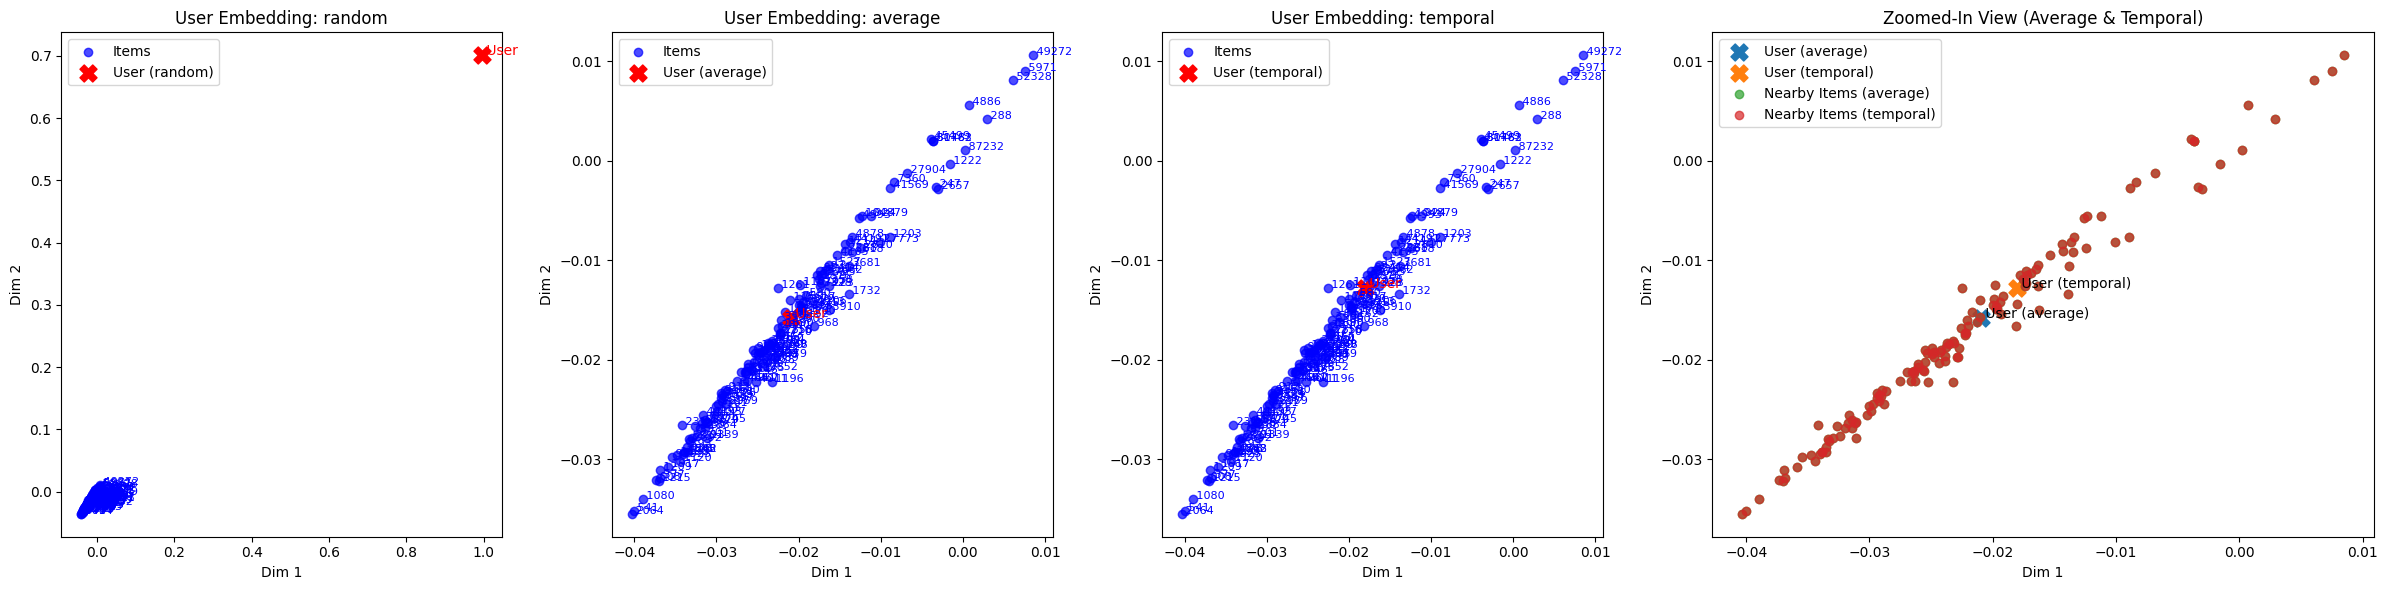


=== User 187 ===
Random embedding (first 3 coords): [0.59918191 0.37465422 0.16830832]
Average embedding (first 3 coords): [-0.02276948 -0.01819228 -0.01529261]
Temporal embedding (first 3 coords): [-0.01276743 -0.00960622 -0.00767901]

Top-3 User Watched Movies:
  Memories of Murder (Salinui chueok) (2003) (Rating: 5.0)
  Downfall (Untergang, Der) (2004) (Rating: 5.0)
  Sideways (2004) (Rating: 5.0)

Top-5 Retrieval Results for Random Embedding:
  80463 (Social Network, The (2010)), dist=0.2261
  81782 (Unstoppable (2010)), dist=0.2261
  4886 (Monsters, Inc. (2001)), dist=0.2462
  49272 (Casino Royale (2006)), dist=0.2559
  7360 (Dawn of the Dead (2004)), dist=0.2581

Top-5 Retrieval Results for Average Embedding:
  2700 (South Park: Bigger, Longer and Uncut (1999)), dist=0.0164
  3000 (Princess Mononoke (Mononoke-hime) (1997)), dist=0.0174
  1206 (Clockwork Orange, A (1971)), dist=0.0182
  1784 (As Good as It Gets (1997)), dist=0.0192
  3160 (Magnolia (1999)), dist=0.0193

Top-5 Ret

<ipython-input-17-b87a6cb82212>:63: RuntimeWarning: overflow encountered in exp
  w = 1.0 / (1.0 + np.exp(-alpha * (t - mean_time)))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

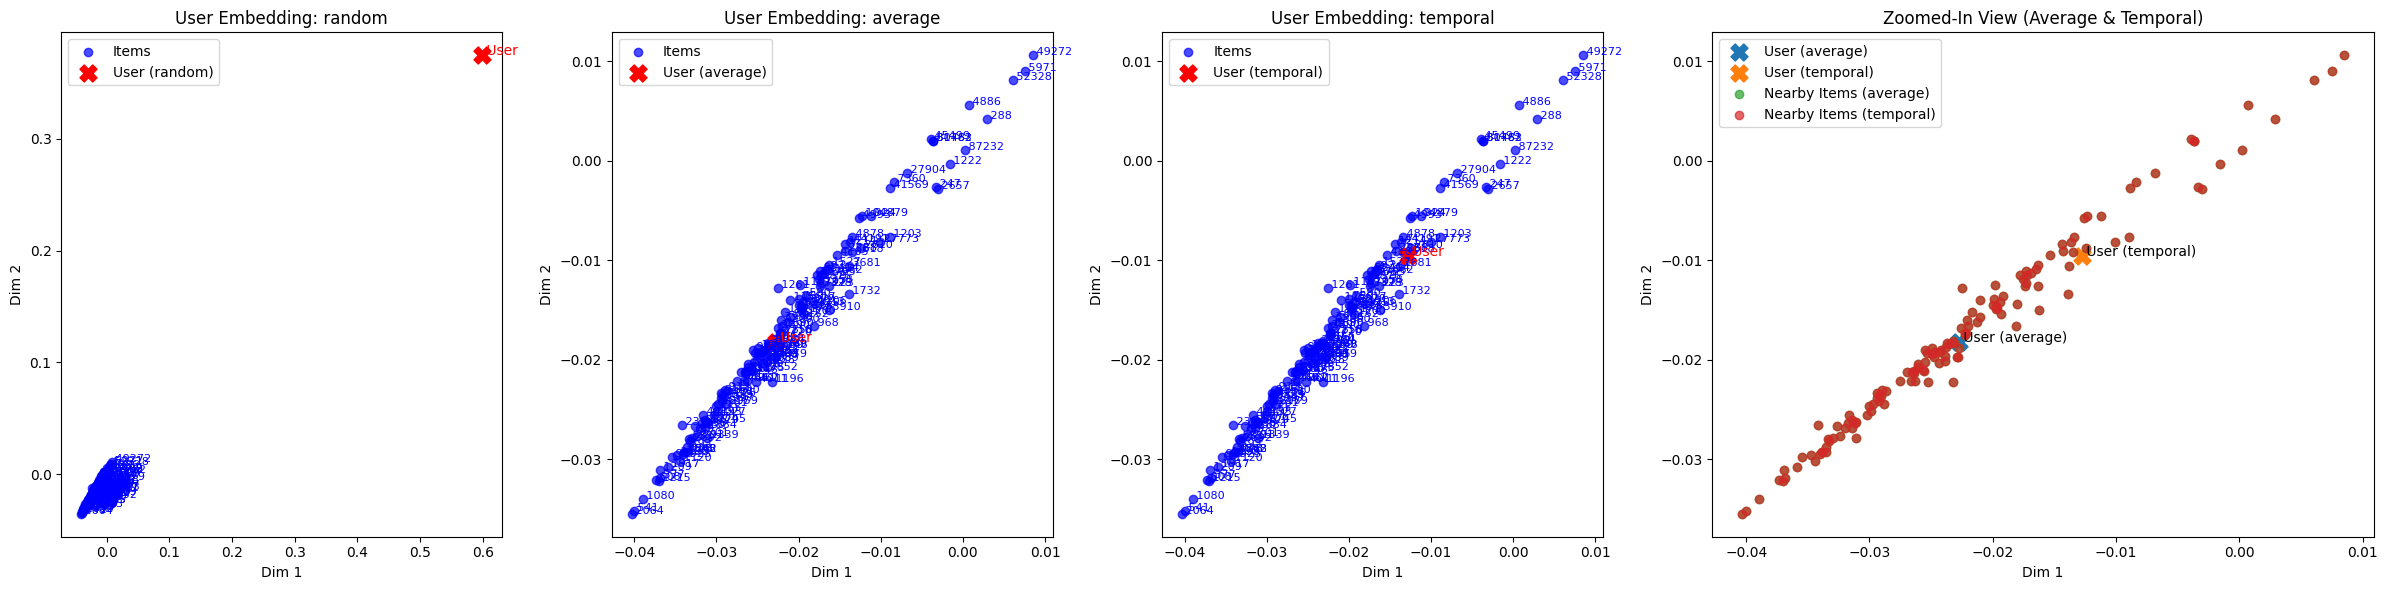

In [19]:
##################################################
#        EXAMPLE USAGE / DEMO
##################################################
import pandas as pd

# Example: Sampling items and corresponding rows in df_ratings
def sample_data_for_demo(df_ratings, df_items, num_items=100):
    """
    Samples a subset of items and their corresponding ratings to speed up processing.

    :param df_ratings: DataFrame containing user-item interactions.
    :param df_items: DataFrame containing item metadata.
    :param num_items: Number of items to sample.
    :return: Filtered df_ratings and df_items.
    """
    # Sample a subset of items
    sampled_item_ids = df_items['itemId'].sample(num_items, random_state=42)

    # Filter df_ratings to include only rows corresponding to the sampled items
    df_ratings_sampled = df_ratings[df_ratings['itemId'].isin(sampled_item_ids)]

    # Filter df_items to include only the sampled items
    df_items_sampled = df_items[df_items['itemId'].isin(sampled_item_ids)]

    return df_ratings_sampled, df_items_sampled



def demo_user_embeddings_and_retrieval(embedding_df, df_ratings, df_items,
                                       user_ids_to_test=[1, 2],
                                       top_N_retrieval=3  # Retrieval stage
                                       ):
    """
    Demonstrates user-embedding methods (random, average, temporal), retrieves top items,
    and visualizes in 2D, with top watched movies and recommendations included.
    """
    # 1) Build the embedding_dict
    embedding_df = embedding_df.dropna(subset=['embeddings'])
    embedding_dict = build_embedding_dict(embedding_df)

    # 2) Build item matrix for retrieval
    item_matrix, item_ids = build_item_matrix(embedding_dict)

    # 3) For each user, compute embeddings with three methods
    for user_id in user_ids_to_test:
        print(f"\n=== User {user_id} ===")

        # Compute embeddings using all three methods
        emb_random = compute_user_embedding(user_id, df_ratings, embedding_dict, method="random")
        emb_average = compute_user_embedding(user_id, df_ratings, embedding_dict, method="average")
        emb_temporal = compute_user_embedding(user_id, df_ratings, embedding_dict, method="temporal")

        # Store embeddings in a dictionary
        user_embeddings_dict = {
            "random": emb_random,
            "average": emb_average,
            "temporal": emb_temporal
        }

        # Print embeddings (first 3 dimensions)
        for method, emb in user_embeddings_dict.items():
            print(f"{method.capitalize()} embedding (first 3 coords): {emb[:3]}")

        # Retrieve user's top-3 watched movies (highest-rated)
        user_ratings = df_ratings[df_ratings['userId'] == user_id].sort_values(by='rating', ascending=False)
        top_movies = user_ratings.merge(df_items, left_on='itemId', right_on='itemId').head(3)
        print("\nTop-3 User Watched Movies:")
        for _, row in top_movies.iterrows():
            print(f"  {row['title']} (Rating: {row['rating']:.1f})")

        # Retrieve top-N items for each method
        for method, emb in user_embeddings_dict.items():
            top_N_results = retrieve_top_N_items(emb, item_matrix, item_ids, N=top_N_retrieval)
            print(f"\nTop-{top_N_retrieval} Retrieval Results for {method.capitalize()} Embedding:")
            for (iid, dist) in top_N_results:
                row = df_items[df_items['itemId'] == iid]
                title = row['title'].values[0] if not row.empty else f"Item {iid}"
                print(f"  {iid} ({title}), dist={dist:.4f}")

        # Visualize in 2D (only works for first 2 dimensions)
        relevant_items = list(set(item_ids))  # Use all items for visualization
        # File name to save
        fileName = f"{embedding_variant}_{NUM_USERS}user_{llm_model}_{user_id}"

        visualize_embeddings_2d(user_embeddings_dict, embedding_dict, relevant_items, fileName)

# Suppose we already loaded embedding_df, df_ratings, df_items
# from your MovieLens pipeline:
#   embedding_df: [itemId, embeddings]
#   df_ratings: [userId, itemId, rating, timestamp]
#   df_items: [itemId, title, genres, etc.]

# Here is how you might call the demo:
# (We assume embedding_df is 3D or we won't see a 3D scatter.)

user_ids_to_test = [1, 2]
num_users_to_test = 2
# 3) Randomly sample user IDs from the dataset
all_user_ids = df_ratings['userId'].unique()
user_ids_to_test = random.sample(list(all_user_ids), min(num_users_to_test, len(all_user_ids)))
print(f"Randomly selected user IDs for testing: {user_ids_to_test}")

# 4) Sample item IDs based on the selected users
sampled_item_ids = df_ratings[df_ratings['userId'].isin(user_ids_to_test)]['itemId'].unique()
print(f"Sampled {len(sampled_item_ids)} unique item IDs based on selected users.")

# 5) Filter embedding_df and df_items for the sampled item IDs
sampled_embedding_df = embedding_df[embedding_df['itemId'].isin(sampled_item_ids)]
sampled_df_items = df_items[df_items['itemId'].isin(sampled_item_ids)]

# Pass the sampled data to your function
demo_user_embeddings_and_retrieval(sampled_embedding_df, df_ratings, df_items_sampled,
                                   user_ids_to_test,
                                   top_N_retrieval=5)


 ## 2.2 Augmentation

"Example calls to create user profiles in both manual and LLM-based ways."

In [20]:
import openai
import pandas as pd
import numpy as np
import time

def augment_user_profile(
    user_id,
    df_ratings,
    df_items,
    method="manual",
    llm_model="gpt-4o-mini",
    api_key=None,
    top_genre_limit=5,  # Limit top genres to the most frequent 5
    top_tag_limit=15    # Limit top tags to the most frequent 15
):
    """
    Build a structured user profile for a single user, limiting the top genres
    and tags to specified numbers.

    Parameters:
    -----------
    - user_id: int
        The user we are analyzing.

    - df_ratings: pd.DataFrame
        Contains [userId, itemId, rating, timestamp] at minimum.

    - df_items: pd.DataFrame
        Contains [itemId, title, genres, tag, ...].

    - method: str, default="manual"
        - "manual": Summarize user tastes in code.
        - "llm": Summarize user tastes using LLM.

    - llm_model: str, default="gpt-4o-mini"
        The OpenAI model name to use if method="llm".

    - api_key: str or None
        The OpenAI API key. Required if method="llm".

    - top_genre_limit: int, default=5
        The number of top genres to include in the user profile.

    - top_tag_limit: int, default=15
        The number of top tags to include in the user profile.

    Returns:
    --------
    - user_profile: dict
        A structured user profile containing fields like:
        {
          "user_id": ...,
          "favorite_genres": [...],
          "favorite_tags": [...],
          "top_items": [
             { "itemId": ..., "title": "..." }, ...
          ],
          "average_rating": ...,
          "overall_taste_summary": "..."
        }
    """

    # Filter only the user’s ratings
    user_df = df_ratings[df_ratings["userId"] == user_id].copy()
    if user_df.empty:
        return {
            "user_id": user_id,
            "favorite_genres": [],
            "favorite_tags": [],
            "top_items": [],
            "average_rating": 0.0,
            "overall_taste_summary": "No data"
        }

    # Merge with item info
    user_merged = user_df.merge(df_items, on="itemId", how="left")

    # Compute average rating
    avg_rating = user_merged["rating"].mean()

    # Sort items by rating desc
    top_items = user_merged.sort_values("rating", ascending=False).head(5)

    # Collect top item info
    top_items_list = []
    for _, row in top_items.iterrows():
        top_items_list.append({
            "itemId": int(row["itemId"]),
            "title": str(row.get("title", "")),
            "rating": float(row["rating"])
        })

    # For genres
    if "genres" in user_merged.columns:
        genre_counts = {}
        for _, row in user_merged.iterrows():
            genres_str = row.get("genres", "")
            if not isinstance(genres_str, str):
                continue
            genres_list = genres_str.split("|")  # Adjust delimiter as necessary
            for g in genres_list:
                g = g.strip()
                if g:
                    genre_counts[g] = genre_counts.get(g, 0) + 1
        # Sort by frequency and limit to the top genres
        favorite_genres = sorted(genre_counts.keys(), key=lambda g: genre_counts[g], reverse=True)[:top_genre_limit]
    else:
        favorite_genres = []

    # For tags
    if "tag" in user_merged.columns:
        tag_counts = {}
        for _, row in user_merged.iterrows():
            tags_value = row.get("tag", [])
            if not isinstance(tags_value, list):
                continue
            for t in tags_value:
                t = t.strip()
                if t:
                    tag_counts[t] = tag_counts.get(t, 0) + 1
        # Sort by frequency and limit to the top tags
        favorite_tags = sorted(tag_counts.keys(), key=lambda t: tag_counts[t], reverse=True)[:top_tag_limit]
    else:
        favorite_tags = []

    # Prepare a basic "manual" summary
    if method == "manual":
        overall_taste_summary = (
            f"This user has rated {len(user_df)} items with an average rating of {avg_rating:.2f}. "
            f"The top genres seem to be {favorite_genres}. "
            f"Frequent tags: {favorite_tags}. "
            "They appear to enjoy these top 5 items: " +
            ", ".join([x["title"] for x in top_items_list]) + "."
        )
    else:
        # method == "llm"
        if api_key is None:
            raise ValueError("api_key is required for LLM-based user profile augmentation.")
        openai.api_key = api_key

        raw_text = f"""
User {user_id} has the following data:
- Average rating: {avg_rating:.2f}
- Favorite genres (by frequency): {favorite_genres}
- Favorite tags (by frequency): {favorite_tags}
- Top 5 highest rated items:
"""

        for x in top_items_list:
            raw_text += f"  - {x['title']} (rating {x['rating']:.1f})\n"

        system_msg = (
            "You are a helpful assistant that summarizes a user's taste in a short paragraph. "
            "Focus on the user's overall preferences and style, then produce a single summary string."
        )
        user_msg = (
            "Here is the raw data for a user's preferences:\n"
            f"{raw_text}\n\n"
            "Please write a concise summary of this user's overall taste. Keep it short but meaningful."
        )

        try:
            response = openai.ChatCompletion.create(
                model=llm_model,
                messages=[
                    {"role": "system", "content": system_msg},
                    {"role": "user", "content": user_msg}
                ],
                max_tokens=200,
                temperature=0.7
            )
            overall_taste_summary = response["choices"][0]["message"]["content"].strip()
        except Exception as e:
            print(f"LLM error for user {user_id}: {e}")
            overall_taste_summary = "LLM summarization failed."

    # Assemble the structured user profile
    user_profile = {
        "user_id": int(user_id),
        "favorite_genres": favorite_genres,
        "favorite_tags": favorite_tags,
        "top_items": top_items_list,
        "average_rating": float(avg_rating),
        "overall_taste_summary": overall_taste_summary
    }

    return user_profile


profile_manual = augment_user_profile(
    user_id=1,
    df_ratings=df_ratings,
    df_items=df_items,
    method="manual",
    top_genre_limit=5,  # Top 5 genres
    top_tag_limit=15    # Top 15 tags
)
display("Manual profile:", profile_manual)


profile_llm = augment_user_profile(
    user_id=1,
    df_ratings=df_ratings,
    df_items=df_items,
    method="llm",
    llm_model="gpt-4o-mini",
    api_key=os.environ.get("OPENAI_API_KEY"),
    top_genre_limit=5,  # Top 5 genres
    top_tag_limit=15    # Top 15 tags
)
display("LLM profile:", profile_llm)



'Manual profile:'

{'user_id': 1,
 'favorite_genres': ['Action', 'Comedy', 'Adventure', 'Drama', 'Thriller'],
 'favorite_tags': [],
 'top_items': [{'itemId': 47,
   'title': 'Seven (a.k.a. Se7en) (1995)',
   'rating': 5.0},
  {'itemId': 50, 'title': 'Usual Suspects, The (1995)', 'rating': 5.0},
  {'itemId': 101, 'title': 'Bottle Rocket (1996)', 'rating': 5.0},
  {'itemId': 231,
   'title': 'Dumb & Dumber (Dumb and Dumber) (1994)',
   'rating': 5.0},
  {'itemId': 216, 'title': 'Billy Madison (1995)', 'rating': 5.0}],
 'average_rating': 4.366379310344827,
 'overall_taste_summary': "This user has rated 232 items with an average rating of 4.37. The top genres seem to be ['Action', 'Comedy', 'Adventure', 'Drama', 'Thriller']. Frequent tags: []. They appear to enjoy these top 5 items: Seven (a.k.a. Se7en) (1995), Usual Suspects, The (1995), Bottle Rocket (1996), Dumb & Dumber (Dumb and Dumber) (1994), Billy Madison (1995)."}

LLM error for user 1: Incorrect API key provided: sk-proj-********************************************************************************************************************************************************ViUA. You can find your API key at https://platform.openai.com/account/api-keys.


'LLM profile:'

{'user_id': 1,
 'favorite_genres': ['Action', 'Comedy', 'Adventure', 'Drama', 'Thriller'],
 'favorite_tags': [],
 'top_items': [{'itemId': 47,
   'title': 'Seven (a.k.a. Se7en) (1995)',
   'rating': 5.0},
  {'itemId': 50, 'title': 'Usual Suspects, The (1995)', 'rating': 5.0},
  {'itemId': 101, 'title': 'Bottle Rocket (1996)', 'rating': 5.0},
  {'itemId': 231,
   'title': 'Dumb & Dumber (Dumb and Dumber) (1994)',
   'rating': 5.0},
  {'itemId': 216, 'title': 'Billy Madison (1995)', 'rating': 5.0}],
 'average_rating': 4.366379310344827,
 'overall_taste_summary': 'LLM summarization failed.'}

 ## 2.3 Generation Step (LLM-based final recommendation)

###"Final RAG stage: Pass a (user_profile + pre-ranked items) to GPT and parse JSON for the recommendation."

In [21]:
!pip install inflect

In [22]:
import json
import openai
import inflect


def method_A_generation(
    user_profile,
    ranked_item_list,
    df_items=None,
    llm_model="gpt-4o-mini",
    api_key=None,
    top_N_retrieval=50,
    top_k_rec=10,
    debug=True,
    return_prompt=False,
    chain_of_thought=False
):
    """
    Takes a user profile + a previously ranked list of items,
    asks the LLM to produce a final recommendation in JSON.

    Behavior controlled by `chain_of_thought`:
      - If chain_of_thought=True:
          The final JSON must include:
             "recommended_item_ids"
             "explanation"
             "chain_of_thought"
      - If chain_of_thought=False:
          The final JSON must ONLY have:
             "recommended_item_ids"
          (No explanation of any kind.)

    Parameters
    ----------
    user_profile : dict
        Contains fields like "user_id", "overall_taste_summary", etc.

    ranked_item_list : list
        A pre-ranked list of items, e.g. [(itemId, distance), ...]

    df_items : pd.DataFrame or None
        If provided, used to look up 'title' or other fields.

    llm_model : str, default="gpt-4o-mini"
        OpenAI model name.

    api_key : str, optional
        OpenAI API key. Required if calling the OpenAI API.

    top_k : int, default=5
        Number of items to present to the LLM as candidates.

    debug : bool, default=True
        Whether to print debug information.

    return_prompt : bool, default=False
        If True, returns the final prompt structure in the output dict.

    chain_of_thought : bool, default=False
        - If True, the LLM must return a "chain_of_thought" AND an "explanation".
        - If False, no explanation or chain-of-thought is returned at all.

    Returns
    -------
    dict
        {
            "model_output": <raw LLM text>,
            "parsed_json": { ... final JSON as a Python dict ... },
            "prompt": { ... }  # only if return_prompt=True
        }
    """

    top_N_retrieval = min(top_N_retrieval, len(ranked_item_list))

    # Create an inflect engine
    p = inflect.engine()

    # Convert the number to words
    top_k_rec_text = p.number_to_words(top_k_rec).upper()
    #print(top_k_rec_text)

    if api_key is None:
        raise ValueError("An OpenAI API key is required.")
    openai.api_key = api_key

    # 1) Slice the top-ranked items we will feed to the LLM
    top_items = ranked_item_list[:top_N_retrieval]

    # 2) Build a text snippet describing the items
    items_text = ""
    for entry in top_items:
        if isinstance(entry, tuple) and len(entry) == 2:
            item_id, score = entry
        else:
            item_id = entry
            score = None

        # Optionally fetch the title from df_items
        title_str = f"Item {item_id}"
        if df_items is not None:
            row = df_items[df_items["itemId"] == item_id]
            if not row.empty:
                title_val = row.iloc[0].get("title", "")
                if title_val:
                    title_str = title_val

        items_text += f"- ID: {item_id}, Title: {title_str}"
        if score is not None:
            items_text += f", Score: {score:.4f}"
        items_text += "\n"

    # 3) Create system & user messages,
    #    based on whether chain_of_thought is True/False.
    if chain_of_thought:
        # Prompt that REQUIRES explanation + chain_of_thought in final JSON
        system_msg = (
            "You are a helpful recommendation assistant. "
            "You have a user profile plus some candidate items. "
            f"You MUST recommend at least {top_k_rec_text} items from the provided list. "
            "Output must be valid JSON with all of these keys:\n"
            "  'recommended_item_ids': array of at least 5 item IDs\n"
            "  'explanation': a short summary\n"
            "  'chain_of_thought': your step-by-step reasoning\n"
            "For example:\n"
            "{\n"
            "  \"recommended_item_ids\": [111, 222, 333, 444, 555],\n"
            "  \"explanation\": \"short reasoning...\",\n"
            "  \"chain_of_thought\": \"step by step reasoning...\"\n"
            "}\n"
            "Make sure the JSON is valid and includes these exact keys."
        )
    else:
        # Prompt that says ONLY produce recommended_item_ids
        system_msg = (
            "You are a helpful recommendation assistant. "
            "You have a user profile plus some candidate items. "
            f"You MUST recommend at least {top_k_rec_text} items from the provided list. "
            "Output must be valid JSON with ONLY one key:\n"
            "  'recommended_item_ids': array of at least 5 item IDs\n"
            "Do NOT include any explanation or chain-of-thought.\n"
            "For example:\n"
            "{\n"
            "  \"recommended_item_ids\": [111, 222, 333, 444, 555]\n"
            "}\n"
            "Make sure the JSON is valid, with no extra keys."
        )

    user_msg = f"""
User Profile for user {user_profile.get('user_id')}:
- Favorite Genres: {user_profile.get('favorite_genres')}
- Favorite Tags: {user_profile.get('favorite_tags')}
- Average Rating: {user_profile.get('average_rating')}
- Top Items: {user_profile.get('top_items')}

Overall Taste Summary:
"{user_profile.get('overall_taste_summary')}"

Candidate items to potentially recommend (already pre-ranked):
{items_text}

Please provide your final JSON as requested above.
"""

    if debug:
        print("=== DEBUG: System Message ===")
        print(system_msg)
        print("=== DEBUG: User Message ===")
        print(user_msg)

    # Keep the prompt in case we want to return it
    prompt = {"system_message": system_msg, "user_message": user_msg}

    # 4) Call the ChatCompletion
    try:
        response = openai.ChatCompletion.create(
            model=llm_model,
            messages=[
                {"role": "system", "content": system_msg},
                {"role": "user", "content": user_msg},
            ],
            max_tokens=1000,
            temperature=0.7
        )
        model_output = response["choices"][0]["message"]["content"].strip()
    except Exception as e:
        print(f"Error calling the LLM: {e}")
        return {
            "model_output": "",
            "parsed_json": {},
            **({"prompt": prompt} if return_prompt else {})
        }

    if debug:
        print("\n=== DEBUG: Raw Model Output ===")
        print(model_output)

    # 5) Parse JSON from model output
    parsed_json = {}
    try:
        first_brace = model_output.find("{")
        last_brace = model_output.rfind("}")
        if first_brace != -1 and last_brace != -1:
            json_str = model_output[first_brace:last_brace + 1]
            parsed_json = json.loads(json_str)
    except Exception as e:
        print(f"JSON parsing error: {e}")
        parsed_json = {}

    # 6) If "recommended_item_ids" is empty or missing, fallback to top-3
    if "recommended_item_ids" not in parsed_json or not parsed_json["recommended_item_ids"]:
        fallback_item_ids = []
        for entry in top_items:
            if isinstance(entry, tuple):
                fallback_item_ids.append(entry[0])
            else:
                fallback_item_ids.append(entry)
        fallback_item_ids = fallback_item_ids[:top_k_rec]
        parsed_json["recommended_item_ids"] = fallback_item_ids

        # If chain_of_thought=True, fill them in blank if missing
        # Otherwise skip them entirely if chain_of_thought=False
        if chain_of_thought:
            if "explanation" not in parsed_json:
                parsed_json["explanation"] = "LLM did not provide an explanation."
            if "chain_of_thought" not in parsed_json:
                parsed_json["chain_of_thought"] = "LLM did not provide chain-of-thought."

    # 7) If chain_of_thought=False, ensure we do NOT leak "explanation" or "chain_of_thought"
    #    in case the model incorrectly included them.
    if not chain_of_thought:
        keys_to_remove = ["explanation", "chain_of_thought"]
        for key in keys_to_remove:
            if key in parsed_json:
                del parsed_json[key]

    # Return final result
    result = {
        "model_output": model_output,
        "parsed_json": parsed_json,
    }
    if return_prompt:
        result["prompt"] = prompt

    return result


## 2.4 End-to-End Demo Code

In [23]:
flag_run_demo = False



if flag_run_demo:
  # Step 1: build embeddings ...
  # Step 2: compute user embedding ...
  # Step 3: retrieve top-N items ...
  # Step 4: build user profile ...
  # Step 5: generate final recommendation ...

  #####################################################
  # 1) Build embeddings + item matrix
  #####################################################
  print("=== STEP 1: Building Embedding Dict & Item Matrix ===")
  embedding_df = embedding_df.dropna(subset=['embeddings'])
  embedding_dict = build_embedding_dict(embedding_df)
  item_matrix, item_ids = build_item_matrix(embedding_dict)

  print(f"Number of items in embedding_dict: {len(embedding_dict)}")
  print(f"item_matrix shape: {item_matrix.shape}")


  #####################################################
  # 2) Compute the user embedding
  #####################################################
  print("\n=== STEP 2: Compute User Embedding ===")
  user_id = 3
  user_emb = compute_user_embedding(
      user_id=user_id,
      df_ratings=df_ratings,
      embedding_dict=embedding_dict,
      method="temporal",
      min_rating_threshold=4.0
  )

  print("User embedding (first 10 dimensions):", user_emb[:10])
  print("Embedding length:", len(user_emb))


  #####################################################
  # 3) Retrieve top-k items
  #####################################################
  print("\n=== STEP 3: Retrieve Top-N Items ===")
  top_N_items = retrieve_top_N_items(
      user_emb=user_emb,
      item_matrix=item_matrix,
      item_ids=item_ids,
      N=top_N_retrieval
  )


  print("Top-5 items (itemId, distance):")
  display(top_N_items)


  #####################################################
  # 4) Build user profile (Code 1)
  #####################################################
  print("\n=== STEP 4: Build User Profile ===")
  user_profile_manual = augment_user_profile(
      user_id=user_id,
      df_ratings=df_ratings,
      df_items=df_items,
      method="manual",  # or "manual",
      api_key=os.environ.get("OPENAI_API_KEY")
  )

  print("User Profile Dictionary:")
  display(user_profile_manual)


  user_profile_llm = augment_user_profile(
      user_id=user_id,
      df_ratings=df_ratings,
      df_items=df_items,
      method="llm",  # or "manual",
      api_key=os.environ.get("OPENAI_API_KEY")
  )

  print("User Profile Dictionary:")
  display(user_profile_llm)

  #####################################################
  # 5) Generate final recommendation (Code 2)
  #####################################################
  print("\n=== STEP 5: Generate Final Recommendation ===")
  recommendation_result = method_A_generation(
      user_profile=user_profile_manual,
      ranked_item_list=top_N_items,
      df_items=df_items,
      llm_model= "gpt-4o-mini",
      api_key=os.environ.get("OPENAI_API_KEY"),
      top_N_retrieval=top_N_retrieval,
      top_k_rec=top_k_rec,
      debug=True,
      return_prompt=False,
      chain_of_thought=False
  )


  print("\n=== Parsed JSON ===")
  display(recommendation_result["parsed_json"])



  print("\n=== STEP 5: Generate Final Recommendation ===")
  recommendation_result = method_A_generation(
      user_profile=user_profile_llm,
      ranked_item_list=top_N_items,
      df_items=df_items,
      llm_model= "gpt-4o-mini",
      api_key=os.environ.get("OPENAI_API_KEY"),
      top_N_retrieval=TOP_N_RETRIEVAL,
      top_k_rec=top_k_rec,
      debug=True,
      return_prompt=True,
      chain_of_thought=False
  )



  print("\n=== Parsed JSON ===")
  display(recommendation_result["parsed_json"])


# 3.Evaluation Workflow

##3.1. Train/Test Split by User

"Train–Test split per user: last x% as test by timestamp."

In [ ]:
###############################################################################
# 3. Evaluation Workflow
################################################################################

def train_test_split_by_user(df_ratings, timestamp_col="timestamp", test_ratio=0.3):
    """
    Splits df_ratings into train/test such that for each user,
    the last <test_ratio> fraction (sorted by timestamp) go to test.
    """
    import math

    df_train_list = []
    df_test_list = []

    grouped = df_ratings.groupby("userId")
    for user_id, group in grouped:
        group_sorted = group.sort_values(by=timestamp_col)
        n_total = len(group_sorted)
        n_test = math.ceil(n_total * test_ratio)
        if n_total <= n_test:
            # if few interactions, all or most to train (or you can handle differently)
            df_train_list.append(group_sorted)
        else:
            df_train_list.append(group_sorted.iloc[:-n_test])
            df_test_list.append(group_sorted.iloc[-n_test:])

    df_train = pd.concat(df_train_list).reset_index(drop=True)
    df_test  = pd.DataFrame()
    if df_test_list:
        df_test = pd.concat(df_test_list).reset_index(drop=True)

    return df_train, df_test

def compute_recall_at_k(pred_items, ground_truth_items, k):
    gt_set = set(ground_truth_items)
    if len(gt_set) == 0:
        return None
    pred_set = set(pred_items[:k])
    intersection = pred_set.intersection(gt_set)
    recall = len(intersection) / len(gt_set)
    return recall

def compute_ndcg_at_k(pred_items, ground_truth_items, k):
    gt_set = set(ground_truth_items)
    if len(gt_set) == 0:
        return None
    import math
    dcg = 0.0
    for i, item in enumerate(pred_items[:k], start=1):
        rel = 1 if item in gt_set else 0
        dcg += (2**rel - 1)/math.log2(i+1)
    ideal_count = min(k, len(gt_set))
    idcg = 0.0
    for i in range(1, ideal_count+1):
        idcg += (2**1 - 1)/math.log2(i+1)
    return 0 if idcg == 0 else dcg/idcg

# Example split
df_train, df_test = train_test_split_by_user(df_ratings, timestamp_col="timestamp", test_ratio=0.3)

# Build embedding dict
embedding_df = embedding_df.dropna(subset=['embeddings'])
embedding_dict = build_embedding_dict(embedding_df)
item_matrix, item_ids = build_item_matrix(embedding_dict)

train_users = set(df_train["userId"].unique())
test_users  = set(df_test["userId"].unique())
valid_users = list(train_users.intersection(test_users))

selected_user_ids = valid_users[:NUM_USERS]


MIN_HIGH_RATING      = 3

results = []
cnt = 0

for user_id in selected_user_ids:
    cnt += 1
    print(f"Processing user {cnt}/{len(selected_user_ids)} -> user_id={user_id}")

    user_test = df_test[df_test['userId'] == user_id]
    user_high = user_test[user_test['rating'] >= MIN_HIGH_RATING]['itemId'].tolist()

    # Compute user embeddings from the full df_ratings or from df_train only
    emb_temp = compute_user_embedding(user_id, df_ratings, embedding_dict, method="temporal")
    emb_avg  = compute_user_embedding(user_id, df_ratings, embedding_dict, method="average")

    # Retrieve top-N
    ret_temp = retrieve_top_N_items(emb_temp, item_matrix, item_ids, N=TOP_N_RETRIEVAL)
    ret_temp_ids = [x[0] for x in ret_temp]
    ret_avg  = retrieve_top_N_items(emb_avg,  item_matrix, item_ids, N=TOP_N_RETRIEVAL)
    ret_avg_ids = [x[0] for x in ret_avg]

    # Build user profile (train data)
    user_data_train = df_train[df_train["userId"] == user_id]
    user_profile_manual = augment_user_profile(user_id, df_train, df_items, method="manual", api_key=os.environ.get("OPENAI_API_KEY"))
    user_profile_llm    = augment_user_profile(user_id, df_train, df_items, method="llm", api_key=os.environ.get("OPENAI_API_KEY"))

    # Final recommendation (temporal retrieval + manual profile)
    no_reason_temp_manual = method_A_generation(
        user_profile=user_profile_manual,
        ranked_item_list=ret_temp,
        df_items=df_items,
        api_key=os.environ.get("OPENAI_API_KEY"),
        top_N_retrieval=TOP_N_RETRIEVAL,
        top_k_rec=TOP_K_RECOMMENDATION,
        debug=False,
        chain_of_thought=False
    )
    rec_no_reason_temp_manual_ids = no_reason_temp_manual["parsed_json"].get("recommended_item_ids", [])

    # Final recommendation (average retrieval + manual profile)
    no_reason_avg_manual = method_A_generation(
        user_profile=user_profile_manual,
        ranked_item_list=ret_avg,
        df_items=df_items,
        api_key=os.environ.get("OPENAI_API_KEY"),
        top_N_retrieval=TOP_N_RETRIEVAL,
        top_k_rec=TOP_K_RECOMMENDATION,
        debug=False,
        chain_of_thought=False
    )
    rec_no_reason_avg_manual_ids = no_reason_avg_manual["parsed_json"].get("recommended_item_ids", [])

    # Final recommendation (temporal retrieval + llm profile)
    no_reason_temp_llm = method_A_generation(
        user_profile=user_profile_llm,
        ranked_item_list=ret_temp,
        df_items=df_items,
        api_key=os.environ.get("OPENAI_API_KEY"),
        top_N_retrieval=TOP_N_RETRIEVAL,
        top_k_rec=TOP_K_RECOMMENDATION,
        debug=False,
        chain_of_thought=False
    )
    rec_no_reason_temp_llm_ids = no_reason_temp_llm["parsed_json"].get("recommended_item_ids", [])

    # Final recommendation (average retrieval + llm profile)
    no_reason_avg_llm = method_A_generation(
        user_profile=user_profile_llm,
        ranked_item_list=ret_avg,
        df_items=df_items,
        api_key=os.environ.get("OPENAI_API_KEY"),
        top_N_retrieval=TOP_N_RETRIEVAL,
        top_k_rec=TOP_K_RECOMMENDATION,
        debug=False,
        chain_of_thought=False
    )
    rec_no_reason_avg_llm_ids = no_reason_avg_llm["parsed_json"].get("recommended_item_ids", [])

    row = {
        "user_id": user_id,
        "user_high_rated_items": user_high,

        "retrieval_temporal": ret_temp_ids,
        "retrieval_average":  ret_avg_ids,

        "rec_no_reason_temp_manual_profile": rec_no_reason_temp_manual_ids,
        "rec_no_reason_avg_manual_profile":  rec_no_reason_avg_manual_ids,
        "rec_no_reason_temp_llm_profile":    rec_no_reason_temp_llm_ids,
        "rec_no_reason_avg_llm_profile":     rec_no_reason_avg_llm_ids
    }
    results.append(row)

df_result = pd.DataFrame(results)
print("\nEvaluation Results (head):")
display(df_result.head(5))

# Compute recall/ndcg for retrieval
K_RETRIEVAL      = TOP_N_RETRIEVAL
K_RECOMMENDATION = TOP_K_RECOMMENDATION

df_result["retrieval_temporal_recall"] = df_result.apply(
    lambda r: compute_recall_at_k(r["retrieval_temporal"], r["user_high_rated_items"], K_RETRIEVAL), axis=1
)
df_result["retrieval_temporal_ndcg"] = df_result.apply(
    lambda r: compute_ndcg_at_k(r["retrieval_temporal"], r["user_high_rated_items"], K_RETRIEVAL), axis=1
)
df_result["retrieval_average_recall"] = df_result.apply(
    lambda r: compute_recall_at_k(r["retrieval_average"], r["user_high_rated_items"], K_RETRIEVAL), axis=1
)
df_result["retrieval_average_ndcg"] = df_result.apply(
    lambda r: compute_ndcg_at_k(r["retrieval_average"], r["user_high_rated_items"], K_RETRIEVAL), axis=1
)

# Compute recall/ndcg for final recommendations
df_result["rec_no_reason_temp_manual_profile_recall"] = df_result.apply(
    lambda r: compute_recall_at_k(r["rec_no_reason_temp_manual_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_temp_manual_profile_ndcg"] = df_result.apply(
    lambda r: compute_ndcg_at_k(r["rec_no_reason_temp_manual_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_avg_manual_profile_recall"] = df_result.apply(
    lambda r: compute_recall_at_k(r["rec_no_reason_avg_manual_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_avg_manual_profile_ndcg"] = df_result.apply(
    lambda r: compute_ndcg_at_k(r["rec_no_reason_avg_manual_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_temp_llm_profile_recall"] = df_result.apply(
    lambda r: compute_recall_at_k(r["rec_no_reason_temp_llm_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_temp_llm_profile_ndcg"] = df_result.apply(
    lambda r: compute_ndcg_at_k(r["rec_no_reason_temp_llm_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_avg_llm_profile_recall"] = df_result.apply(
    lambda r: compute_recall_at_k(r["rec_no_reason_avg_llm_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)
df_result["rec_no_reason_avg_llm_profile_ndcg"] = df_result.apply(
    lambda r: compute_ndcg_at_k(r["rec_no_reason_avg_llm_profile"], r["user_high_rated_items"], K_RECOMMENDATION), axis=1
)

print("\nFinal df_result with metrics:")
display(df_result.head(5))

# Show average metrics
start_col = "retrieval_temporal_recall"
start_idx = list(df_result.columns).index(start_col)
selected_columns = df_result.iloc[:, start_idx+1:]
column_means = selected_columns.mean(numeric_only=True)

print("\n### Average Values Over Users ###\n")
for col, avg in column_means.items():
    print(f"{col}: {avg:.6f}")

In [ ]:
# Provide links to download files in Google Colab
import google.colab.files

# Save DataFrame as CSV
df_path = f"/content/recResults_ds_name_{ds_name}_NUM_USERS_{NUM_USERS}_attack_scenario_{selected_embedding_column}.csv"
df_result.to_csv(df_path, index=False)

# Save list as CSV
list_path = f"/content/attackIds_ds_name_{ds_name}_{selected_embedding_column}.csv"
pd.DataFrame({"itemId": attacked_item_ids_list}).to_csv(list_path, index=False)

# Confirm file saved correctly by displaying its content
list_df = pd.read_csv(list_path)

# Download both files
google.colab.files.download(df_path)
google.colab.files.download(list_path)

In [ ]:
2################################################################################
# Example: Counting positions of attacked items
################################################################################

def count_attacked_items_positions(
    df_result: pd.DataFrame,
    attacked_item_ids_list: list[int],
    approach_columns: list[str],
    user_id_col: str = "user_id"
) -> pd.DataFrame:
    """
    For each user, and for each approach column (which is a list of recommended items),
    find the rank of each attacked item (if present).
    """
    records = []
    for idx, row in df_result.iterrows():
        user_id = row[user_id_col]
        for approach in approach_columns:
            rec_list = row[approach]

            # If rec_list is stored as a string, parse it
            if isinstance(rec_list, str):
                rec_list = ast.literal_eval(rec_list)

            if not isinstance(rec_list, list):
                continue

            item2rank = {item: (i+1) for i, item in enumerate(rec_list)}
            for attacked_item in attacked_item_ids_list:
                rank_position = item2rank.get(attacked_item, None)
                records.append({
                    user_id_col: user_id,
                    'approach': approach,
                    'item_id': attacked_item,
                    'rank_position': rank_position
                })

    return pd.DataFrame(records)

approaches = [
    "retrieval_temporal", "retrieval_average",
    "rec_no_reason_temp_manual_profile", "rec_no_reason_avg_manual_profile",
    "rec_no_reason_temp_llm_profile", "rec_no_reason_avg_llm_profile"
]

df_positions = count_attacked_items_positions(
    df_result=df_result,
    attacked_item_ids_list=attacked_item_ids_list,
    approach_columns=approaches,
    user_id_col="user_id"
)
print("\nAttacked Items' Positions in Recommendations:")
display(df_positions.head(20))

print("\nAverage rank of attacked items (ignoring None):")
avg_rank = (
    df_positions.dropna(subset=["rank_position"])
                .groupby("approach")["rank_position"]
                .mean()
                .sort_values()
)
display(avg_rank)


print("\nOverall Average Rank of Attacked Items (ignoring None):")
overall_avg_rank = df_positions.dropna(subset=["rank_position"])["rank_position"].mean()
print(overall_avg_rank)

In [ ]:
def compute_recall_at_k(pred_items, ground_truth_items, k):
    """
    Compute Recall@K: Fraction of relevant items in the top-K recommendations.
    """
    gt_set = set(ground_truth_items)
    if len(gt_set) == 0:
        return None  # Handle edge case with no ground truth
    pred_set = set(pred_items[:k])
    intersection = pred_set.intersection(gt_set)
    recall = len(intersection) / len(gt_set)
    return recall

def compute_ndcg_at_k(pred_items, ground_truth_items, k):
    """
    Compute NDCG@K: Normalized Discounted Cumulative Gain for ranking relevance.
    """
    gt_set = set(ground_truth_items)
    if len(gt_set) == 0:
        return None  # Handle edge case with no ground truth
    import math
    dcg = 0.0
    for i, item in enumerate(pred_items[:k], start=1):
        rel = 1 if item in gt_set else 0
        dcg += (2**rel - 1) / math.log2(i + 1)
    ideal_count = min(k, len(gt_set))
    idcg = 0.0
    for i in range(1, ideal_count + 1):
        idcg += (2**1 - 1) / math.log2(i + 1)
    return 0 if idcg == 0 else dcg / idcg


def evaluate_accuracy(df_result, top_k_retrieval=50, top_k_recommendation=10):
    """
    Computes Recall@K and NDCG@K for retrieval and recommendation stages.
    """
    metrics = []

    for _, row in df_result.iterrows():
        ground_truth = row["user_high_rated_items"]

        # Retrieval Stage Metrics
        retrieval_temp_recall = compute_recall_at_k(row["retrieval_temporal"], ground_truth, top_k_retrieval)
        retrieval_temp_ndcg = compute_ndcg_at_k(row["retrieval_temporal"], ground_truth, top_k_retrieval)
        retrieval_avg_recall = compute_recall_at_k(row["retrieval_average"], ground_truth, top_k_retrieval)
        retrieval_avg_ndcg = compute_ndcg_at_k(row["retrieval_average"], ground_truth, top_k_retrieval)

        # Recommendation Stage Metrics
        rec_temp_manual_recall = compute_recall_at_k(row["rec_no_reason_temp_manual_profile"], ground_truth, top_k_recommendation)
        rec_temp_manual_ndcg = compute_ndcg_at_k(row["rec_no_reason_temp_manual_profile"], ground_truth, top_k_recommendation)
        rec_avg_manual_recall = compute_recall_at_k(row["rec_no_reason_avg_manual_profile"], ground_truth, top_k_recommendation)
        rec_avg_manual_ndcg = compute_ndcg_at_k(row["rec_no_reason_avg_manual_profile"], ground_truth, top_k_recommendation)
        rec_temp_llm_recall = compute_recall_at_k(row["rec_no_reason_temp_llm_profile"], ground_truth, top_k_recommendation)
        rec_temp_llm_ndcg = compute_ndcg_at_k(row["rec_no_reason_temp_llm_profile"], ground_truth, top_k_recommendation)
        rec_avg_llm_recall = compute_recall_at_k(row["rec_no_reason_avg_llm_profile"], ground_truth, top_k_recommendation)
        rec_avg_llm_ndcg = compute_ndcg_at_k(row["rec_no_reason_avg_llm_profile"], ground_truth, top_k_recommendation)

        metrics.append({
            "retrieval_temporal_recall": retrieval_temp_recall,
            "retrieval_temporal_ndcg": retrieval_temp_ndcg,
            "retrieval_average_recall": retrieval_avg_recall,
            "retrieval_average_ndcg": retrieval_avg_ndcg,
            "rec_no_reason_temp_manual_profile_recall": rec_temp_manual_recall,
            "rec_no_reason_temp_manual_profile_ndcg": rec_temp_manual_ndcg,
            "rec_no_reason_avg_manual_profile_recall": rec_avg_manual_recall,
            "rec_no_reason_avg_manual_profile_ndcg": rec_avg_manual_ndcg,
            "rec_no_reason_temp_llm_profile_recall": rec_temp_llm_recall,
            "rec_no_reason_temp_llm_profile_ndcg": rec_temp_llm_ndcg,
            "rec_no_reason_avg_llm_profile_recall": rec_avg_llm_recall,
            "rec_no_reason_avg_llm_profile_ndcg": rec_avg_llm_ndcg,
        })

    return pd.DataFrame(metrics)


# Usage
accuracy_metrics = evaluate_accuracy(df_result)
print("Accuracy Metrics:")
display(accuracy_metrics.describe())


In [ ]:
import pandas as pd
import ast

approaches = [
    "retrieval_temporal",
    "rec_no_reason_temp_llm_profile",
    "rec_no_reason_avg_llm_profile"
]
def measure_popularity_class_distribution(
    df_result: pd.DataFrame,
    df_items: pd.DataFrame,
    approach_columns: list[str],
    user_id_col: str = "user_id"
) -> pd.DataFrame:
    """
    Given df_result with final recommendations and df_items containing 'pop_class',
    compute how many recommended items fall into each pop_class for each approach.

    df_items must have columns ['itemId', 'pop_class'].

    Returns a DataFrame with columns:
        [approach, pop_class, count, percentage]
    """
    records = []

    # Ensure df_items has the needed columns
    if "itemId" not in df_items.columns or "pop_class" not in df_items.columns:
        raise ValueError("df_items must have ['itemId', 'pop_class'] columns.")

    for approach in approach_columns:
        # Gather all recommended items from that approach
        all_items = []
        for _, row in df_result.iterrows():
            rec_list = row[approach]
            # If stored as string, parse
            if isinstance(rec_list, str):
                rec_list = ast.literal_eval(rec_list)
            if isinstance(rec_list, list):
                all_items.extend(rec_list)

        if not all_items:
            continue

        # Merge with df_items on itemId => get pop_class
        rec_df = pd.DataFrame({"itemId": all_items})
        merged = pd.merge(rec_df, df_items[["itemId", "pop_class"]], on="itemId", how="left")

        # Count distribution
        dist = merged["pop_class"].value_counts(dropna=False).reset_index()
        dist.columns = ["pop_class", "count"]
        dist["approach"] = approach
        total_count = dist["count"].sum()
        dist["percentage"] = dist["count"] / total_count * 100.0

        records.append(dist)

    final_df = pd.concat(records, ignore_index=True)
    final_df = final_df[["approach", "pop_class", "count", "percentage"]]
    return final_df

df_pop_dist = measure_popularity_class_distribution(df_result, df_items, approaches)
print("Popularity Distribution:")
display(df_pop_dist)


In [ ]:
def measure_coverage(
    df_result: pd.DataFrame,
    df_items: pd.DataFrame,
    approach_columns: list[str],
    user_id_col: str = "user_id"
) -> pd.DataFrame:
    """
    For each approach, measure coverage = (# unique recommended items) / (total items in df_items).
    Returns a DataFrame with columns: [approach, coverage].
    """
    total_items = df_items["itemId"].nunique()
    coverage_records = []

    import ast
    for approach in approach_columns:
        recommended_items = set()
        for _, row in df_result.iterrows():
            rec_list = row[approach]
            if isinstance(rec_list, str):
                rec_list = ast.literal_eval(rec_list)
            if not isinstance(rec_list, list):
                continue
            for itm in rec_list:
                recommended_items.add(itm)

        coverage_val = len(recommended_items) / total_items if total_items > 0 else 0
        coverage_records.append({"approach": approach, "coverage": coverage_val})

    return pd.DataFrame(coverage_records)

df_coverage = measure_coverage(df_result, df_items, approaches)
display(df_coverage)


In [ ]:
import math
import ast

def build_item_popularity_dict(df_ratings, item_id_col='itemId'):
    """
    Count how many times each item appears in df_ratings => popularity.
    Returns dict: {itemId: count}
    """
    pop_count = df_ratings.groupby(item_id_col).size().to_dict()
    return pop_count

def compute_novelty(recommended_items, pop_dict):
    """
    novelty = average of -log2(pop_fraction)
    pop_fraction(item) = pop_dict[item]/(sum of all pop_dict values).
    If item not in pop_dict, treat it as count=1 to avoid log(0).
    """
    total_count = sum(pop_dict.values())
    if total_count == 0 or len(recommended_items) == 0:
        return 0.0

    sum_info = 0.0
    for item in recommended_items:
        cnt = pop_dict.get(item, 1)
        fraction = cnt / total_count
        sum_info += -math.log2(fraction)
    return sum_info / len(recommended_items)

def measure_novelty(
    df_result: pd.DataFrame,
    df_ratings: pd.DataFrame,
    approach_columns: list[str]
) -> pd.DataFrame:
    """
    For each approach, compute average novelty of the recommended items.
    """
    pop_dict = build_item_popularity_dict(df_ratings)
    records = []

    for approach in approach_columns:
        all_items = []
        for _, row in df_result.iterrows():
            rec_list = row[approach]
            if isinstance(rec_list, str):
                rec_list = ast.literal_eval(rec_list)
            if isinstance(rec_list, list):
                all_items.extend(rec_list)

        val = compute_novelty(all_items, pop_dict)
        records.append({"approach": approach, "novelty": val})

    return pd.DataFrame(records)

df_novelty = measure_novelty(df_result, df_ratings, approaches)
display(df_novelty)


In [ ]:
def measure_tail_fraction(
    df_result: pd.DataFrame,
    df_items: pd.DataFrame,
    approach_columns: list[str],
    tail_label=2
) -> pd.DataFrame:
    """
    Fraction of recommended items that are in the 'tail' (pop_class=2).
    """
    from ast import literal_eval
    df_items_small = df_items[["itemId", "pop_class"]].dropna()

    records = []
    for approach in approach_columns:
        all_items = []
        for _, row in df_result.iterrows():
            rec_list = row[approach]
            if isinstance(rec_list, str):
                rec_list = literal_eval(rec_list)
            if isinstance(rec_list, list):
                all_items.extend(rec_list)

        if not all_items:
            records.append({"approach": approach, "tail_fraction": 0.0})
            continue

        rec_df = pd.DataFrame({"itemId": all_items})
        merged = pd.merge(rec_df, df_items_small, on="itemId", how="left")
        # Suppose missing pop_class => not tail
        merged["pop_class"] = merged["pop_class"].fillna(-1)

        # Fraction
        tail_count = (merged["pop_class"] == tail_label).sum()
        frac = tail_count / len(merged)
        records.append({"approach": approach, "tail_fraction": frac})

    return pd.DataFrame(records)

# 1) Popularity distribution by approach (uses df_items.pop_class)
df_pop_dist = measure_popularity_class_distribution(df_result, df_items, approaches)
display(df_pop_dist)

# 2) Coverage
df_coverage = measure_coverage(df_result, df_items, approaches)
display(df_coverage)

# 3) Novelty
df_novelty = measure_novelty(df_result, df_ratings, approaches)
display(df_novelty)

# 4) Tail fraction
df_tail = measure_tail_fraction(df_result, df_items, approaches)
display(df_tail)
